# DATA VISUALIZATION

* [Setting-up](#setting_up)
* [Bar Chart](#bar_chart)
* [Boxplot](#box_plot)
* [Lineplot](#line_plot)
* [Scatter plot](#scatter_plot)
* [Heatmap](#heatmap)

## Setting-up <a id="setting_up"></a>

In [1]:
%run data_cleaning.ipynb
%run data_exploration.ipynb

Total number of rows:  11619
Total number of columns:  19


In [2]:
import pandas as pd

from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")

There are some outliers in the data set for ticket_price. Those are removed for data visualization, as it may significantly influence statistics.

In [3]:
dataset=dataset.loc[(dataset.ticket_price<6000)].reset_index(drop=True)

- Create a column "date" as the booking date and convert to datetime (day_scrap, hour_scrap)

In [4]:
cur_time = datetime.datetime.now()
year = cur_time.strftime('%Y')

dataset['date']=pd.to_datetime(dataset['day_scrap'].astype(str) + ' ' + 'May' + ' ' + year + ' '+ dataset['hour_scrap'].astype(str), format='%d %b %Y %H')

- Compute total duration, named "tot_duration", of a round trip (out_duration, in_duration)

In [5]:
dataset['tot_duration'] = (dataset["out_duration"] + dataset["in_duration"]).reset_index(drop=True)

- Separate New York City observations from Sao Paulo

In [6]:
nyc=dataset.loc[dataset.arr_city=='JFK'].reset_index(drop=True)
sao=dataset.loc[dataset.arr_city=='GRU'].reset_index(drop=True)

## Bar chart <a id="bar_chart"></a>

#### a. Count of flights by destination and airline company

To begin with, a general overview of the data set is provided below. It represents the number and frequency of flights based on the destination and airline company.

In [7]:
barplot = dataset.groupby(["arr_city", "out_airline_company"]).size().reset_index(name="N")
barplot["group_count"] = barplot.groupby("arr_city")["N"].transform("sum")
barplot['percent']=barplot['N']/barplot["group_count"]
barplot

,arr_city,out_airline_company,N,group_count,percent
0,GRU,Lufthansa,2984,5613,0.531623
1,GRU,Swiss,2629,5613,0.468377
2,JFK,Lufthansa,2875,5923,0.485396
3,JFK,Swiss,3048,5923,0.514604


This bar chart is accompanied by a legend that distinguishes both airline companies, facilitating a straightforward comparison between them. In fact, it can be observed that Lufthansa operates more flights to São Paulo (53.16%), while Swiss Airline has a higher number of flights to New York City (51.46%). However, there is no significant differences that could imply higher popularity of one destination over another nor dominance of one airline company over another, making these comparable in terms of price for our analysis.

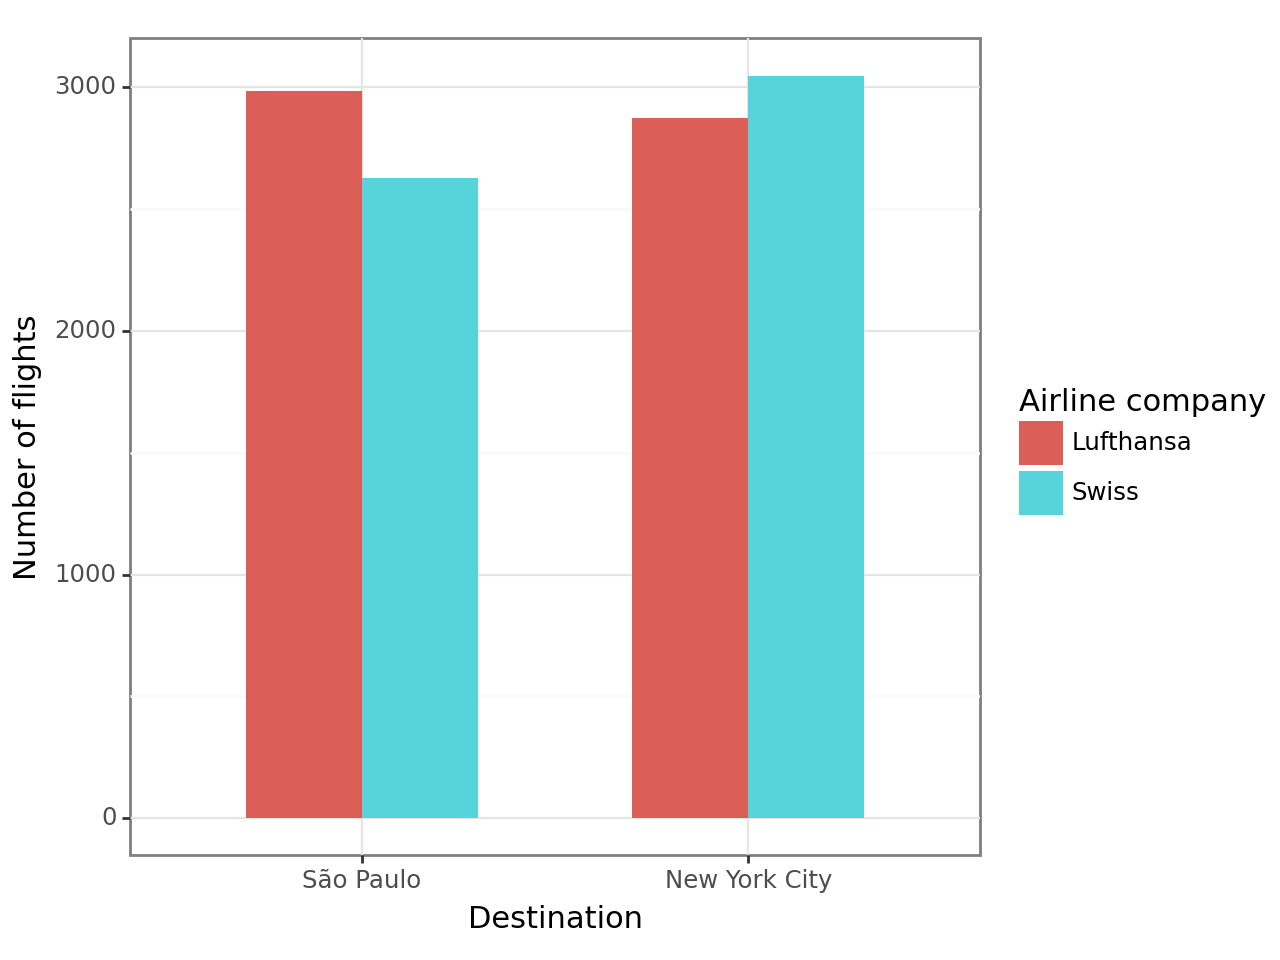

<Figure Size: (640 x 480)>

In [8]:
f1= (ggplot(barplot, aes(x="arr_city", y="N", fill="out_airline_company"))
+ geom_bar(stat="identity", position="dodge", width=0.6, size=0.5)
+ labs(x="Destination", y="Number of flights", fill="Airline company")
+ scale_x_discrete(labels=["São Paulo", "New York City"])
+ theme_bw()
)
f1

#### b. Minimum ticket prices based on the day of the week

Additional bar charts display the minimum ticket prices for different days of the week, comparing the prices and variation for the two airline companies. This time, bars are stacked, allowing for easy visual comparison between the two companies for each destination. Indeed, there is a clear variation of prices, mainly due to Swiss Airline that tends to increase or decrease its prices more than Lufthansa.

In [9]:
def bar_chart(dataset):
    barplot=dataset.filter(['date','ticket_price','out_airline_company'])
    barplot['day_of_week'] = dataset['date'].dt.strftime('%A')
    
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    barplot['day_of_week'] = pd.Categorical(barplot['day_of_week'], categories=weekday_order, ordered=True)
    
    min_prices = barplot.groupby(['day_of_week','out_airline_company'])['ticket_price'].min().reset_index()
    
    f2=(ggplot(min_prices, aes(x='day_of_week', y="ticket_price", fill='out_airline_company'))
    + geom_bar(stat="identity", position="stack", width=0.8, size=0.9)
    + labs(x="Day of the week", y="Ticket price", fill="Airline")
    + scale_fill_discrete(labels=["Lufthansa", "Swiss"])
    + theme_bw()
    )
    print(f2)
    

**From Brussels to New York City**

For NYC, it seems buying flight tickets on Monday, Tuesday, Saturday or Sunday would be more beneficial. In addition, prices of flights operated by Lufthansa are more stable than Swiss Airline.

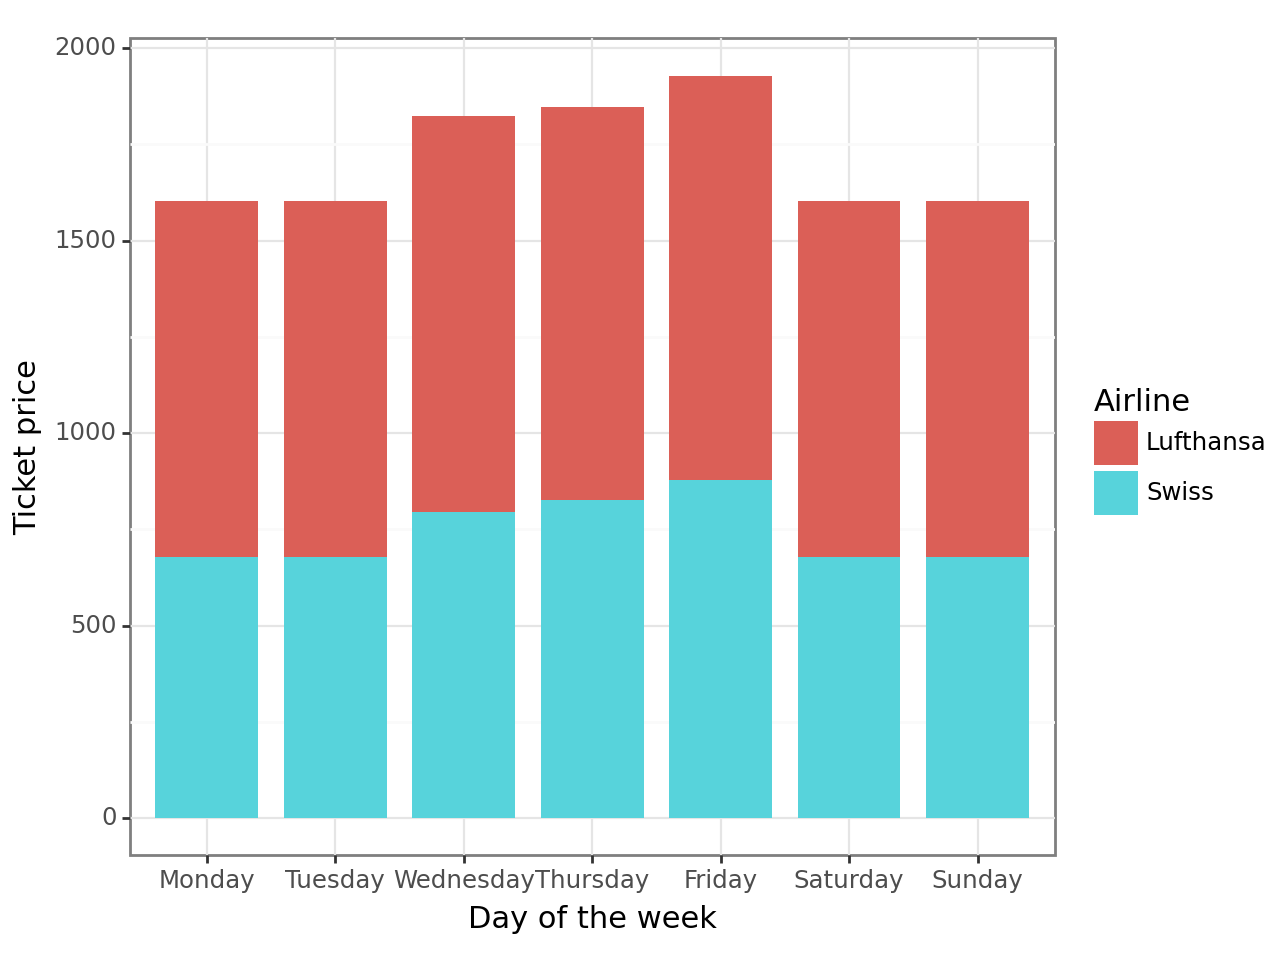

In [10]:
bar_chart(nyc)

**From Brussels to Sao Paulo**

For Sao Paulo, Swiss Airline has significantly deacreased its prices on Tuesday compared to other days of the week.

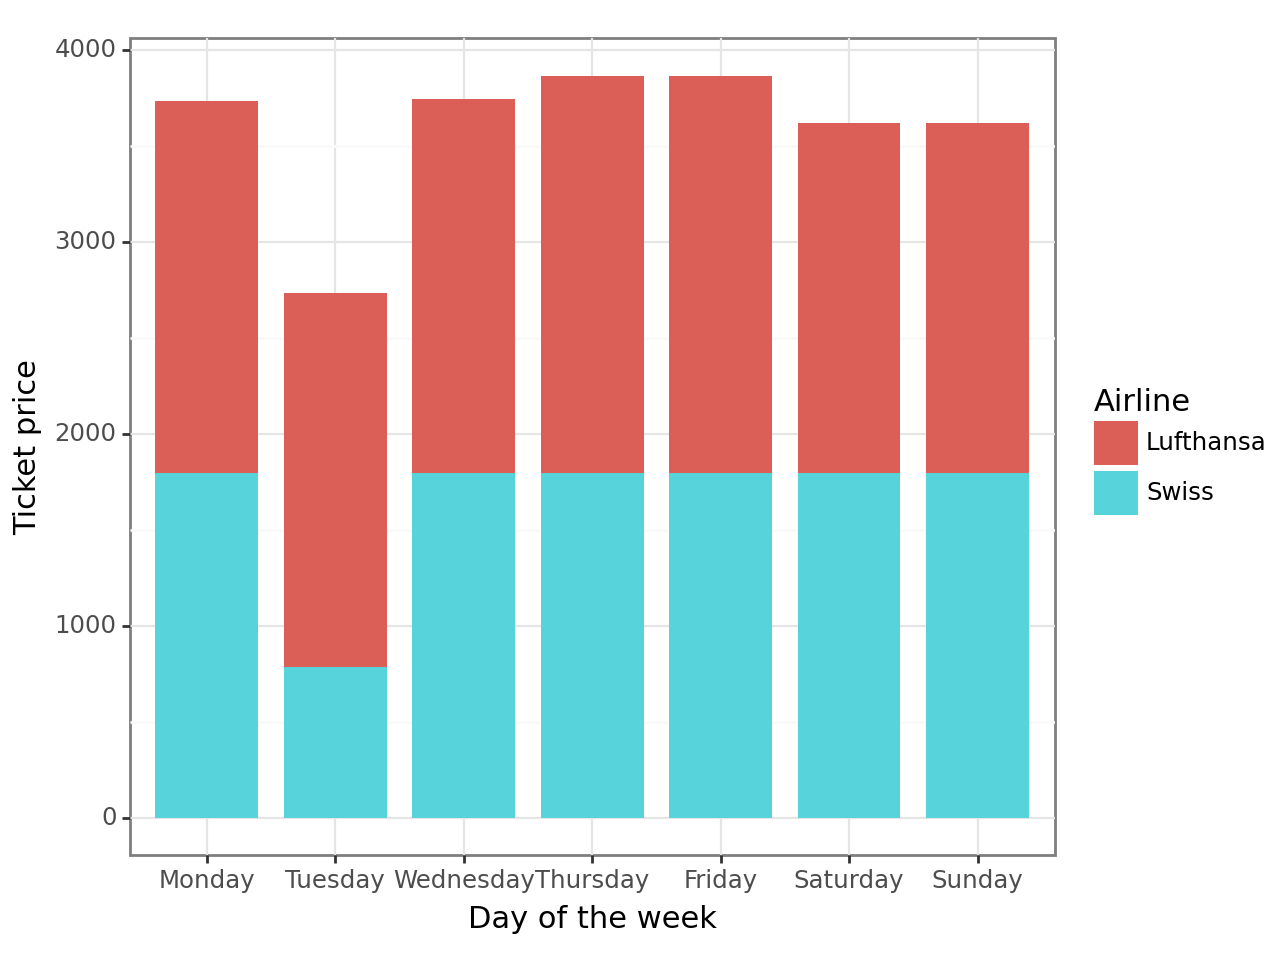

In [11]:
bar_chart(sao)

## Boxplot <a id="box_plot"></a>

These boxplots provide insights into the distribution of prices, specifically its central tendency, spread, and presence of outliers.

In [12]:
def boxplot(dataset):
    f3 = (
    ggplot(dataset, aes(y='ticket_price', x='out_airline_company'))
    + geom_boxplot(color="blue", size=0.5, width=0.1, alpha=0.5)
    + labs(x="Cities", y="Prices")
    + theme_bw()
    )
    f3
    f3 = f3 + stat_boxplot(geom = "errorbar", width = 0.05,  size = 0.5, color = 'blue')
    f3

    print(f3 + stat_summary(fun_data="mean_se", geom="point", size=4, color="red", fill="red"))


**From Brussels to New York City**

The analysis reveals that, in the case of flights to New York City, that there is a noticeable and higher variability in prices associated with Swiss Airline. The price range for this destination is around 1000, but outliers can be observed from the airline Lufthansa. Those are any data points going beyond the whiskers.

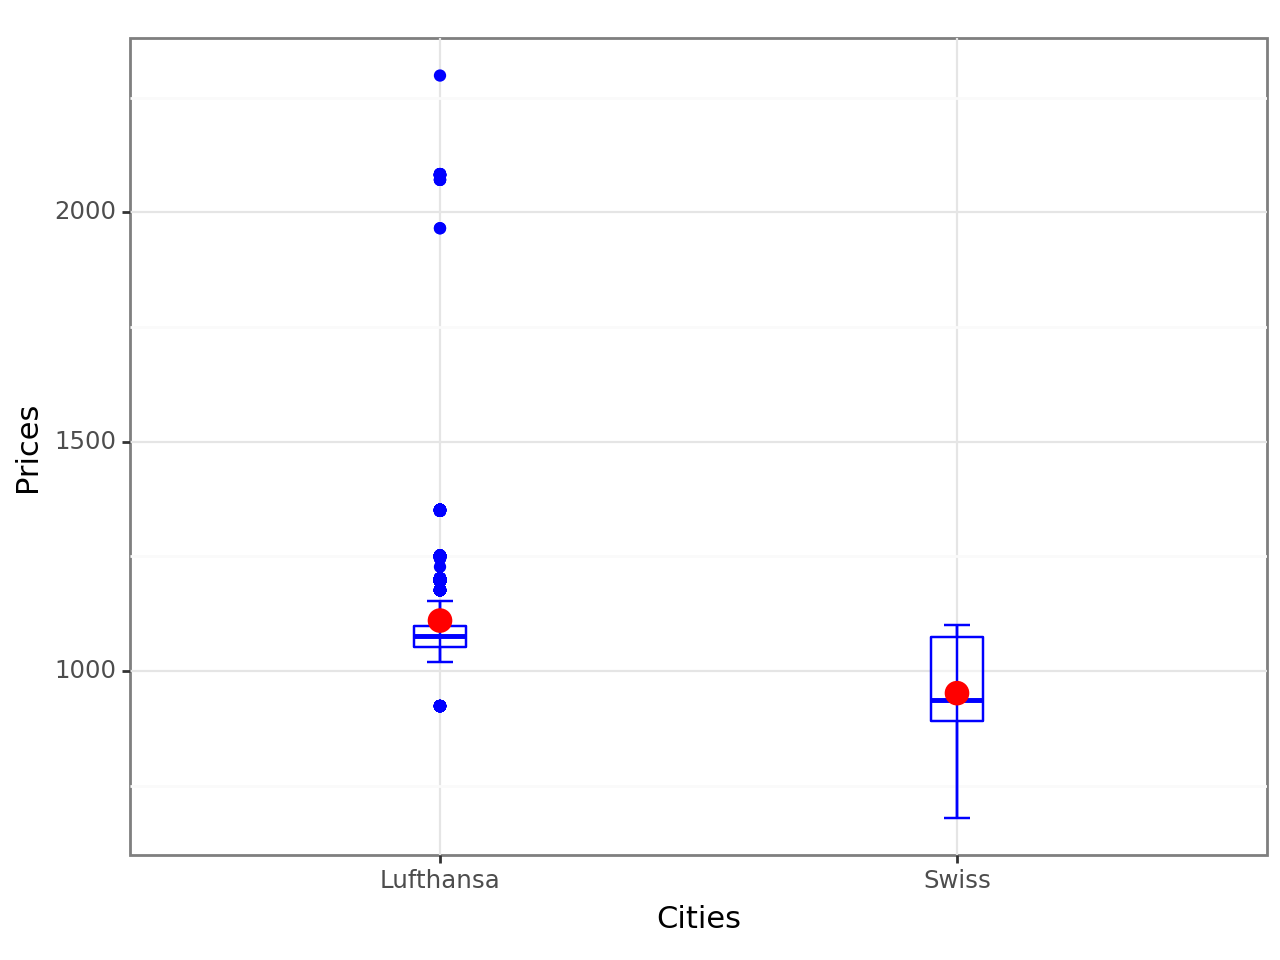

In [13]:
boxplot(nyc)

**From Brussels to Sao Paulo**

The opposite can be observed in the case of Sao Paulo in which the box for Lufthansa is longer, suggesting a larger spread of prices within that airline company.The red point provides an additional measure of central tendency and complements the box plot by showing that Swiss Airline offers lower ticket prices in average.

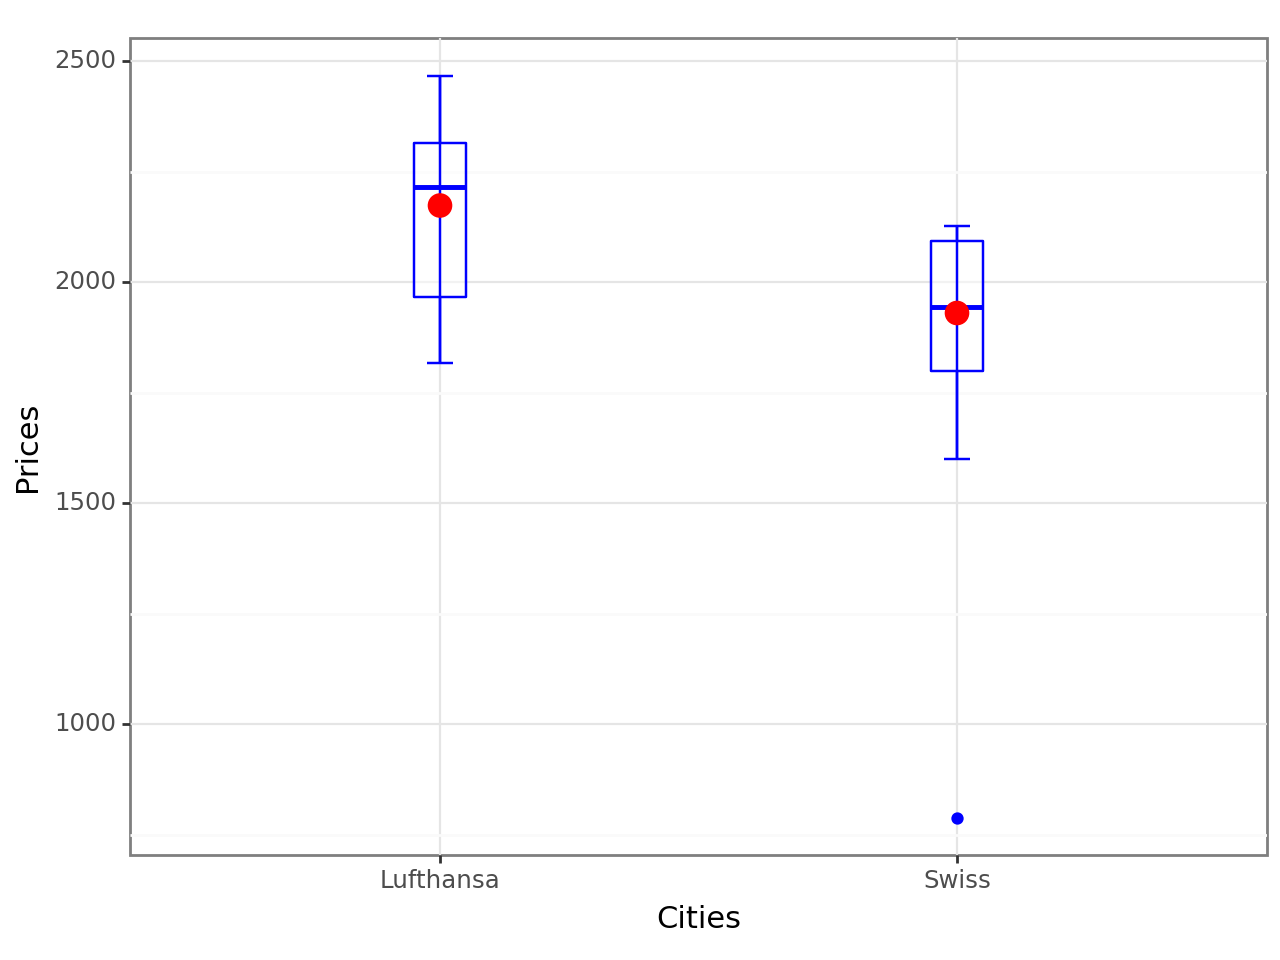

In [14]:
boxplot(sao)

## Lineplot <a id="line_plot"></a>

One of the primary goals of this project is to assist travelers in identifying the optimal time to book flights. To achieve this, line plots are employed to visualize the variations in flight prices over time.

### a. Based on booking day

In [15]:
def lineplot_day(dataset):
    # booking day
    lineplot=dataset.filter(['date', 'arr_city','out_airline_company','ticket_price'])
    lineplot['day_booking']=lineplot['date'].dt.strftime('%d %b')

    # min price per day
    day_price=lineplot.groupby(['day_booking','out_airline_company'])['ticket_price'].agg(['min','mean','max'])
    day_price=day_price.reset_index()
    
    # transform to list
    date = day_price[day_price.out_airline_company=='Lufthansa']['day_booking'].tolist()
    price_lufthansa= day_price[day_price.out_airline_company == 'Lufthansa']['mean'].tolist()
    price_swiss= day_price[day_price.out_airline_company == 'Swiss']['mean'].tolist()
   
    # lineplot
    fig, ax1 = plt.subplots(figsize = (20,15))

    ax1.plot(date, price_lufthansa, "-s", color = 'k')
    plt.xticks(rotation=90)
    ax1.set_ylabel("Lufthansa price [€]", color = 'k')
    ax2 = ax1.twinx()
    ax2.plot(date, price_swiss,"-s",color = "royalblue")
    ax2.set_ylabel("Swiss price [€]", color = "royalblue")

    plt.xticks(rotation=90)
    plt.title('Flight (average) prices based on booking date');

As the departure date was approaching, the average price of tickets for both destinations did begin to increase and varied more. It highlights the importance of considering the timing of booking to secure more favorable prices. Swiss Airline exhibits rather consistent increase for New York City and Sao Paulo, while Lufthansa’s prices trend is less obvious. 

**From Brussels to New York City**

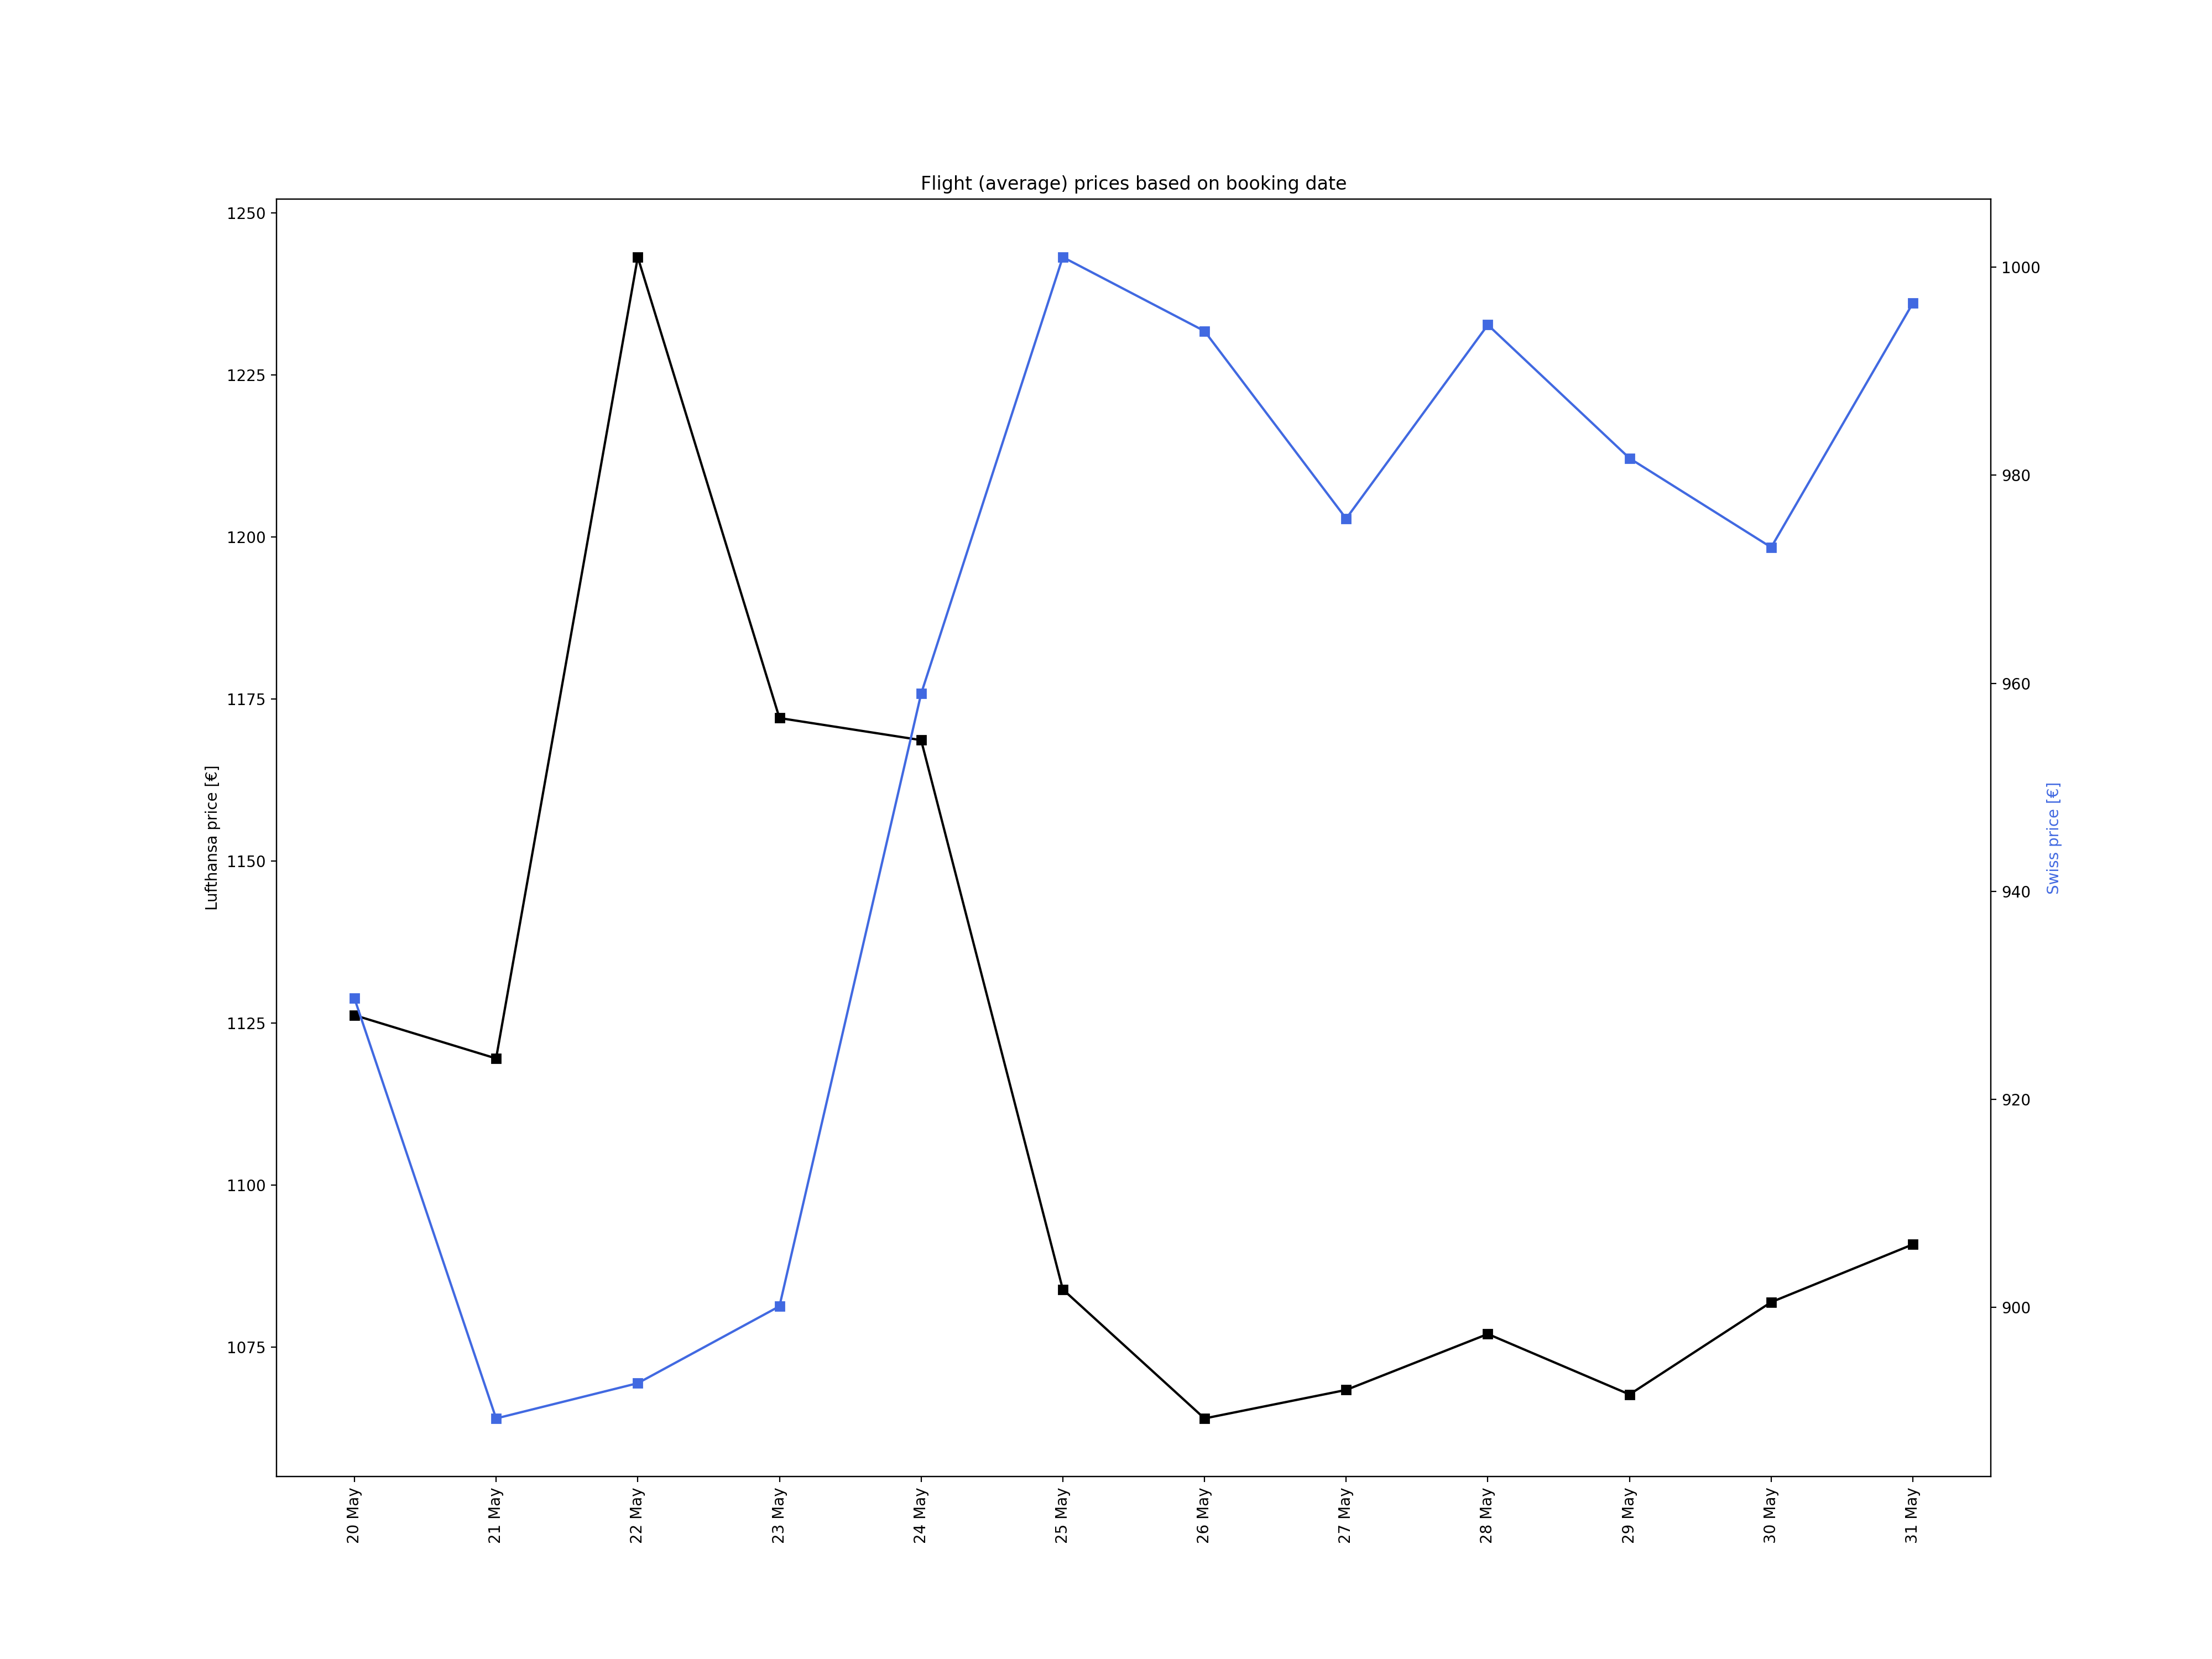

In [16]:
lineplot_day(dataset=nyc)

**From Brussels to Sao Paulo**

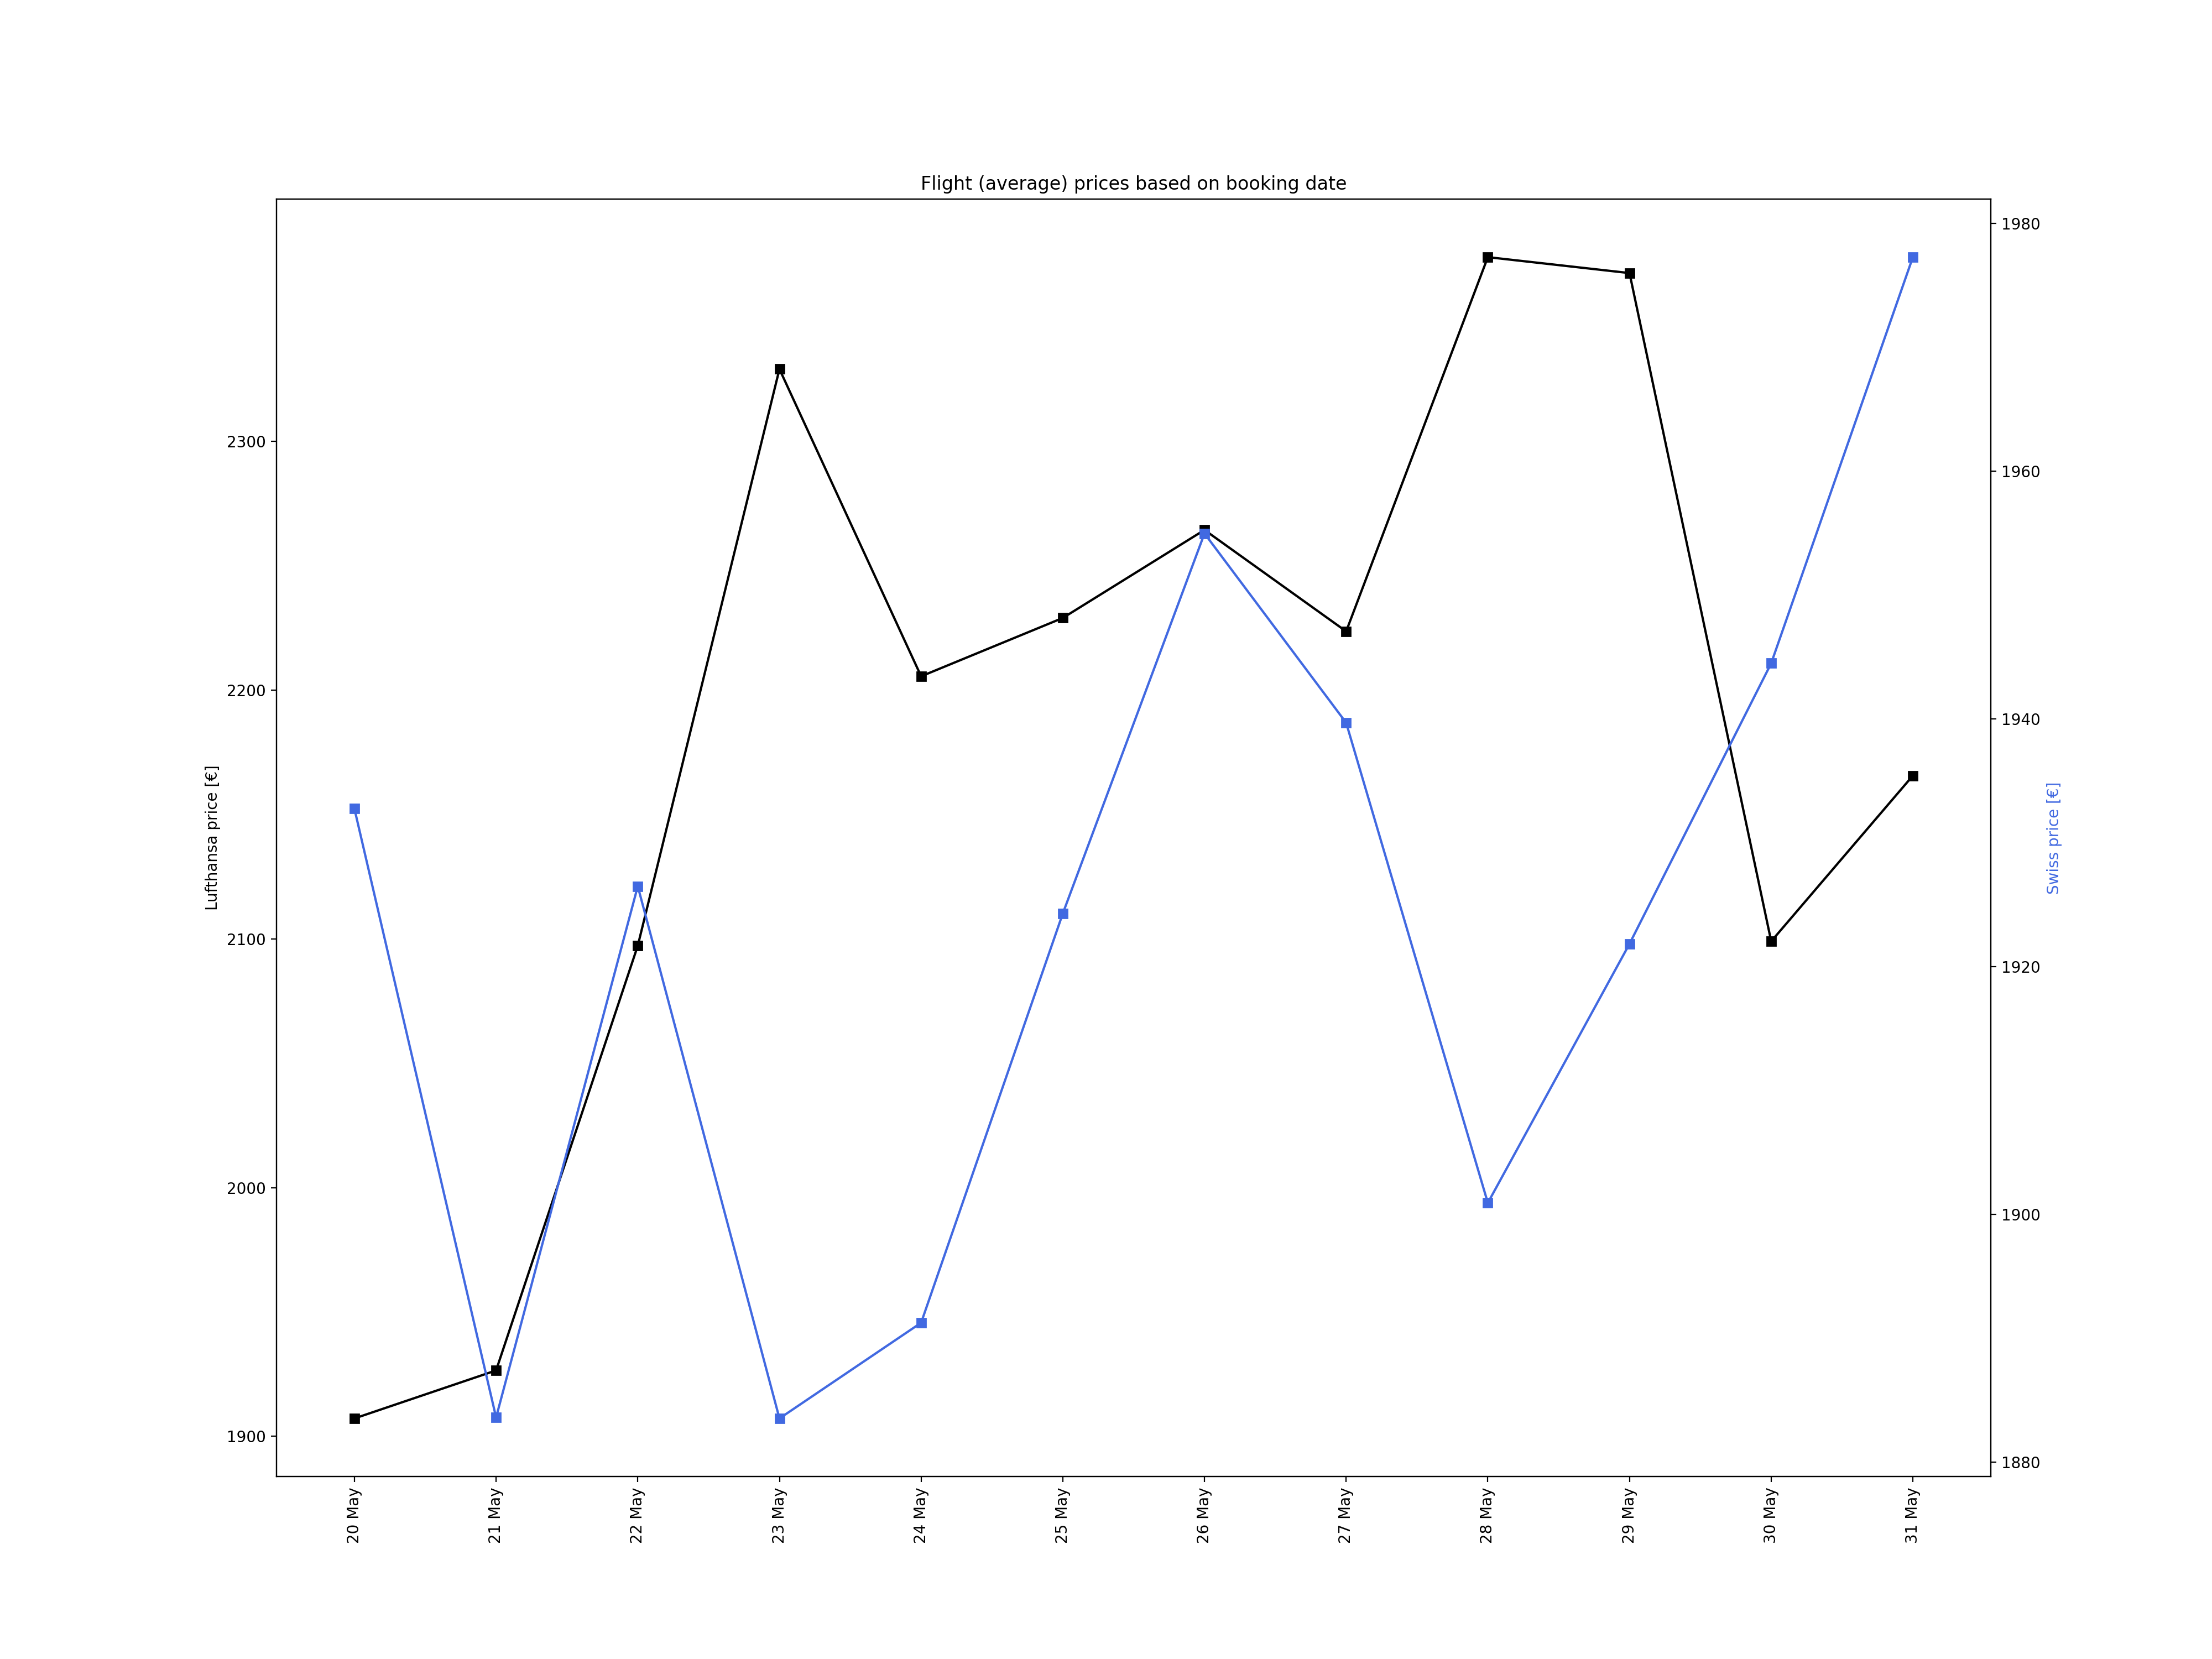

In [17]:
lineplot_day(dataset=sao)

### b. Based on booking time

In [18]:
def lineplot_time(dataset):
    lineplot = dataset.groupby(['out_airline_company','date'])['ticket_price'].agg(['min','mean','max'])
    lineplot = lineplot.reset_index()
    lineplot['date'] = lineplot['date'].dt.strftime('%d %b %I %p')

    date= lineplot[lineplot.out_airline_company == 'Lufthansa']['date'].tolist()
    price_lufthansa = lineplot[lineplot.out_airline_company == 'Lufthansa']['mean'].tolist()
    price_swiss = lineplot[lineplot.out_airline_company == 'Swiss']['mean'].tolist()
    price_swiss = price_swiss[:len(date)]

    # lineplot
    fig, ax1 = plt.subplots(figsize = (20,15))

    ax1.plot(date, price_lufthansa, color = 'k')
    plt.xticks(rotation=90)
    ax1.set_ylabel("Lufthansa price [€]", color = 'k')

    ax2 = ax1.twinx()
    ax2.plot(date, price_swiss, color = "royalblue")
    ax2.set_ylabel("Swiss price [€]", color = "royalblue")

    plt.xticks(rotation=90)
    plt.title('Flight (average) prices based on booking date');

**From Brussels to New York City**

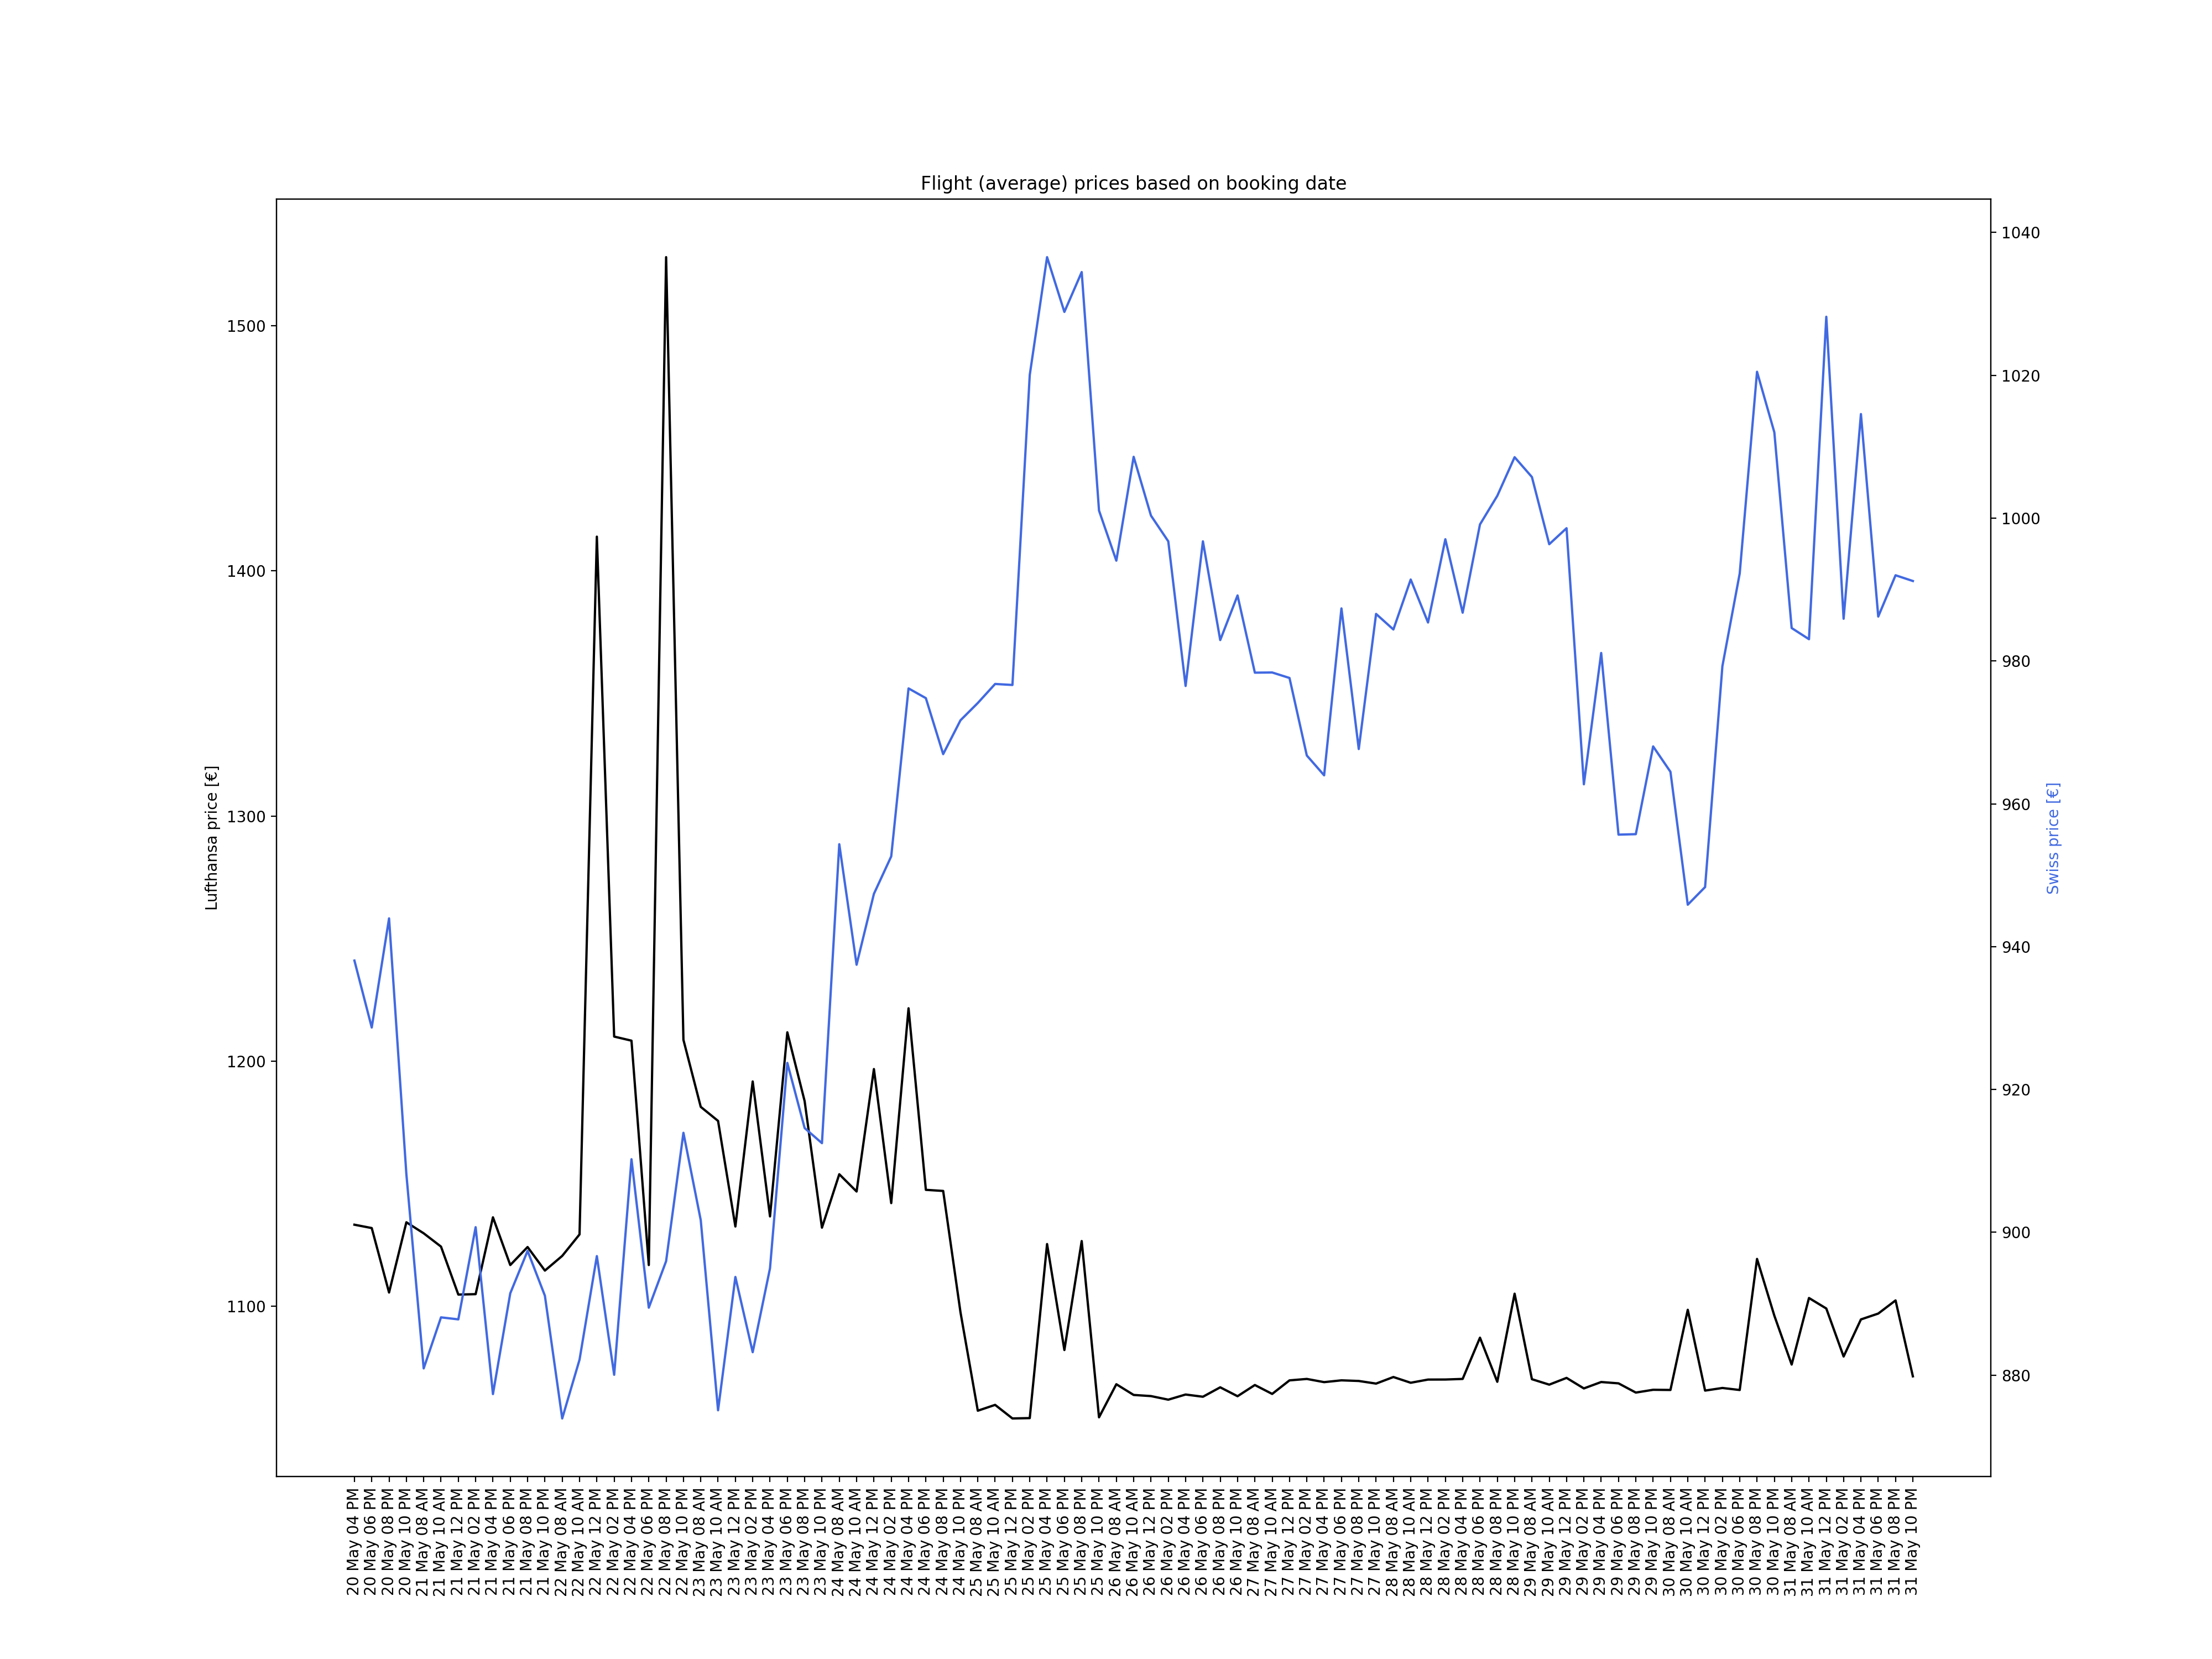

In [19]:
lineplot_time(dataset=nyc)

**From Brussels to Sao Paulo**

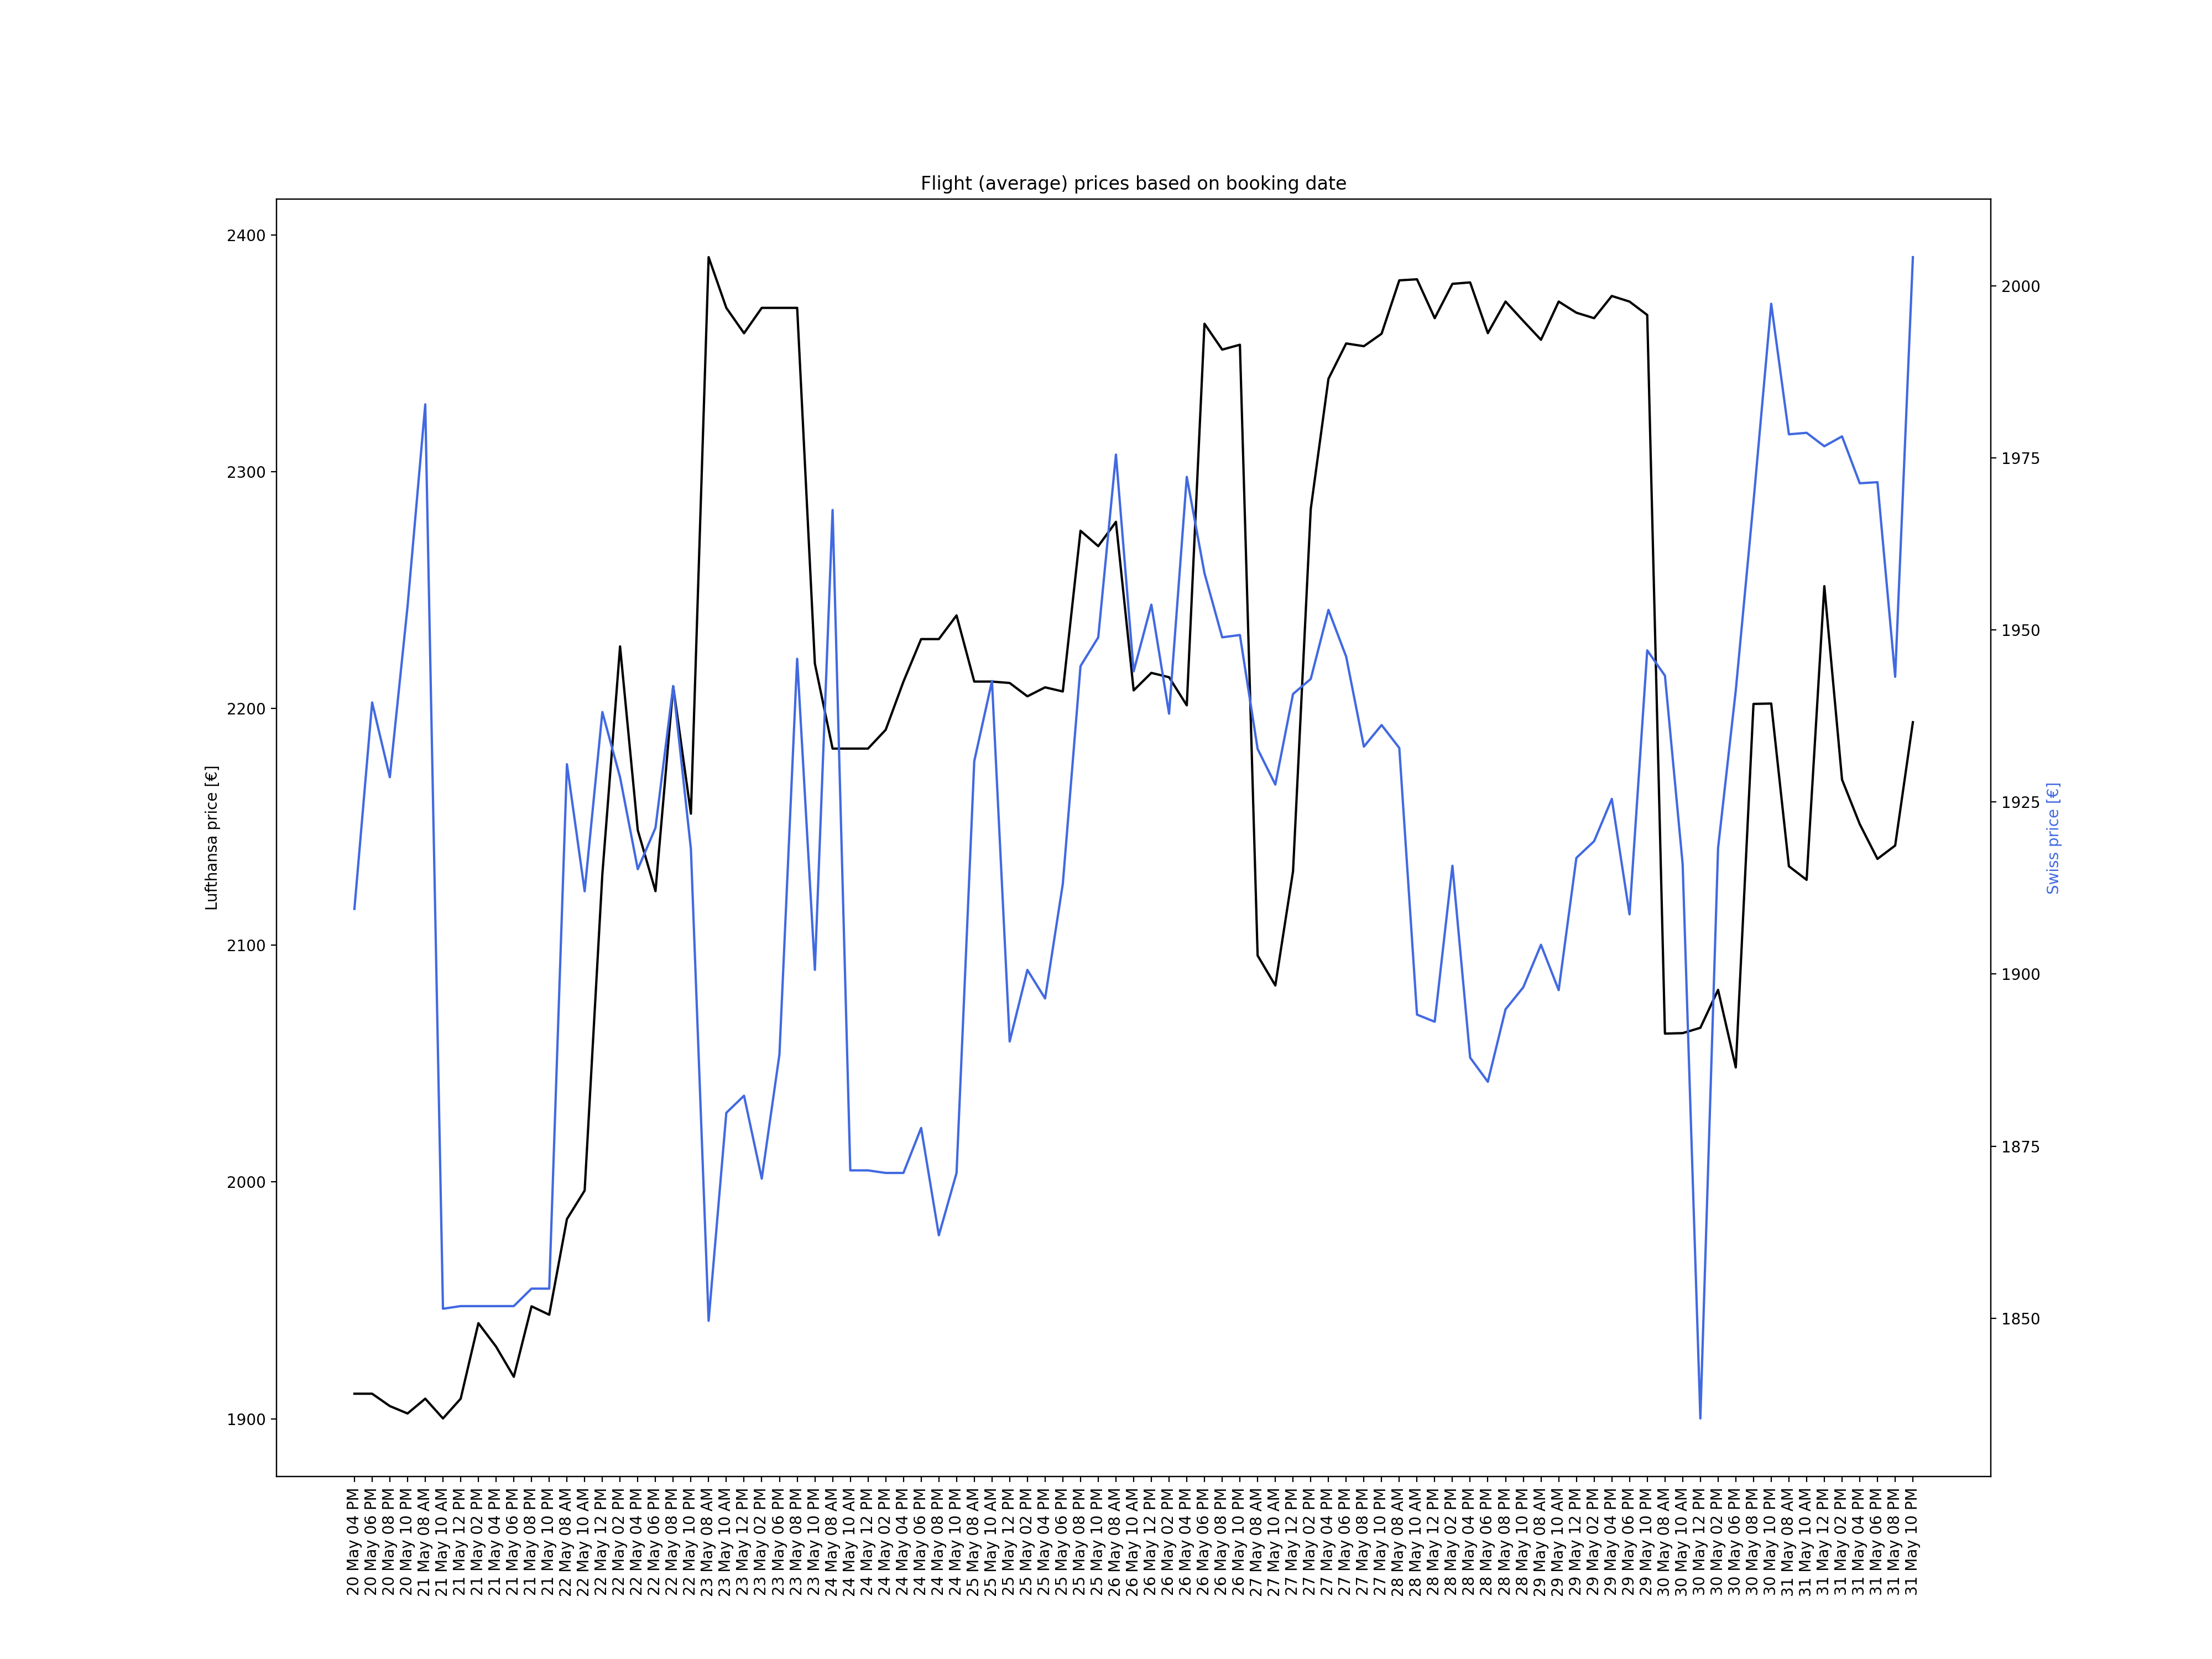

In [20]:
lineplot_time(dataset=sao)

### c. Cost vs duration of flight

In [21]:
def duration_lineplot(dataset):
    plot_data = dataset[["ticket_price", "tot_duration", "out_airline_company"]]
    sns.lineplot(data=plot_data, x='tot_duration', y='ticket_price', hue='out_airline_company', estimator='mean')

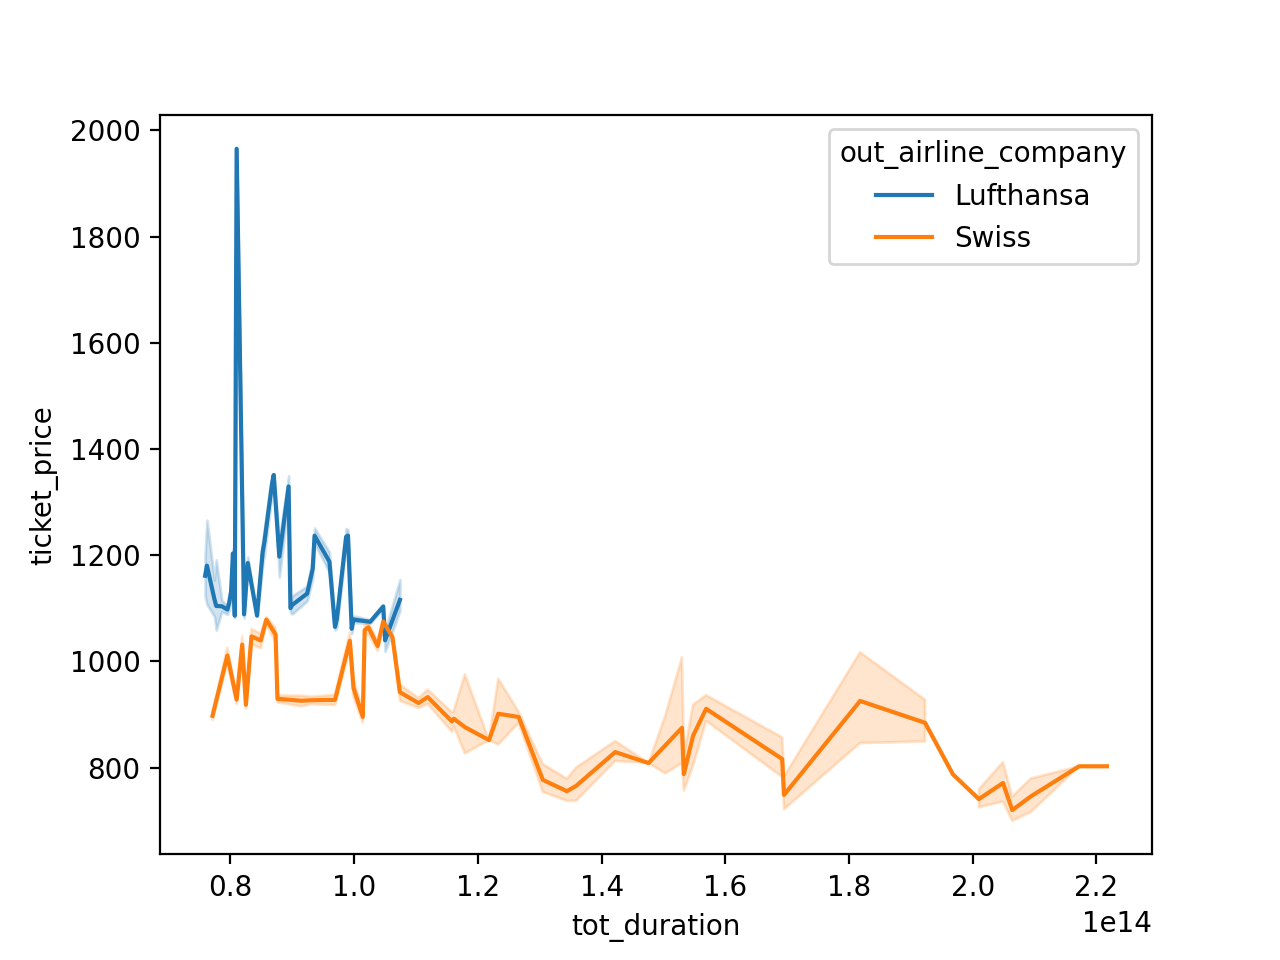

In [22]:
duration_lineplot(dataset=nyc)

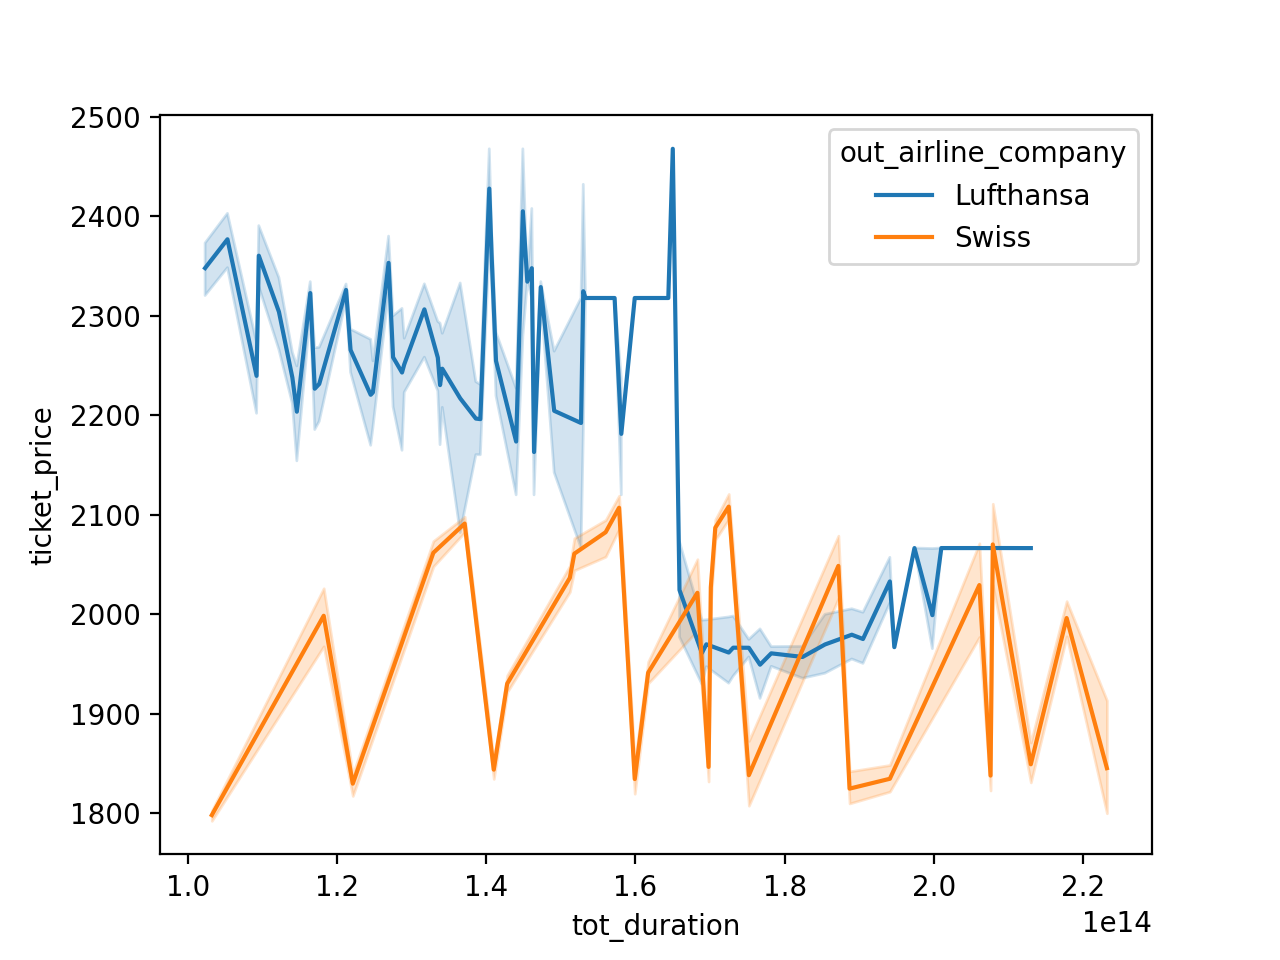

In [23]:
duration_lineplot(dataset=sao)

## Scatter plot <a id="scatter_plot"></a>

### a. Cost vs duration of flight

Scatter plots are effective for representing the relationship between the cost and duration of flights. Indeed, a visual assessment of the correlation between these two variables is made easier. 

In [24]:
def scatterplot(dataset):
    scatter_plot = dataset.groupby(['out_airline_company','tot_duration'])['ticket_price'].mean().reset_index(name='price')
    f6= (ggplot(scatter_plot, aes(x='tot_duration', y='price', color='out_airline_company')) + \
    geom_point() + \
    labs(title='Cost vs duration of the flight',
         x='Flight duration',
         y='Flight Price',
         color='Airline') + \
    theme_bw()
    )
    print(f6)

**From Brussels to New York City**

The scatter plot for New York City shows a clear negative relationship between the price and duration of the flight, indicating that flight with longer durations tend to be less expensive. This feature might be interesting in predicting flight prices.

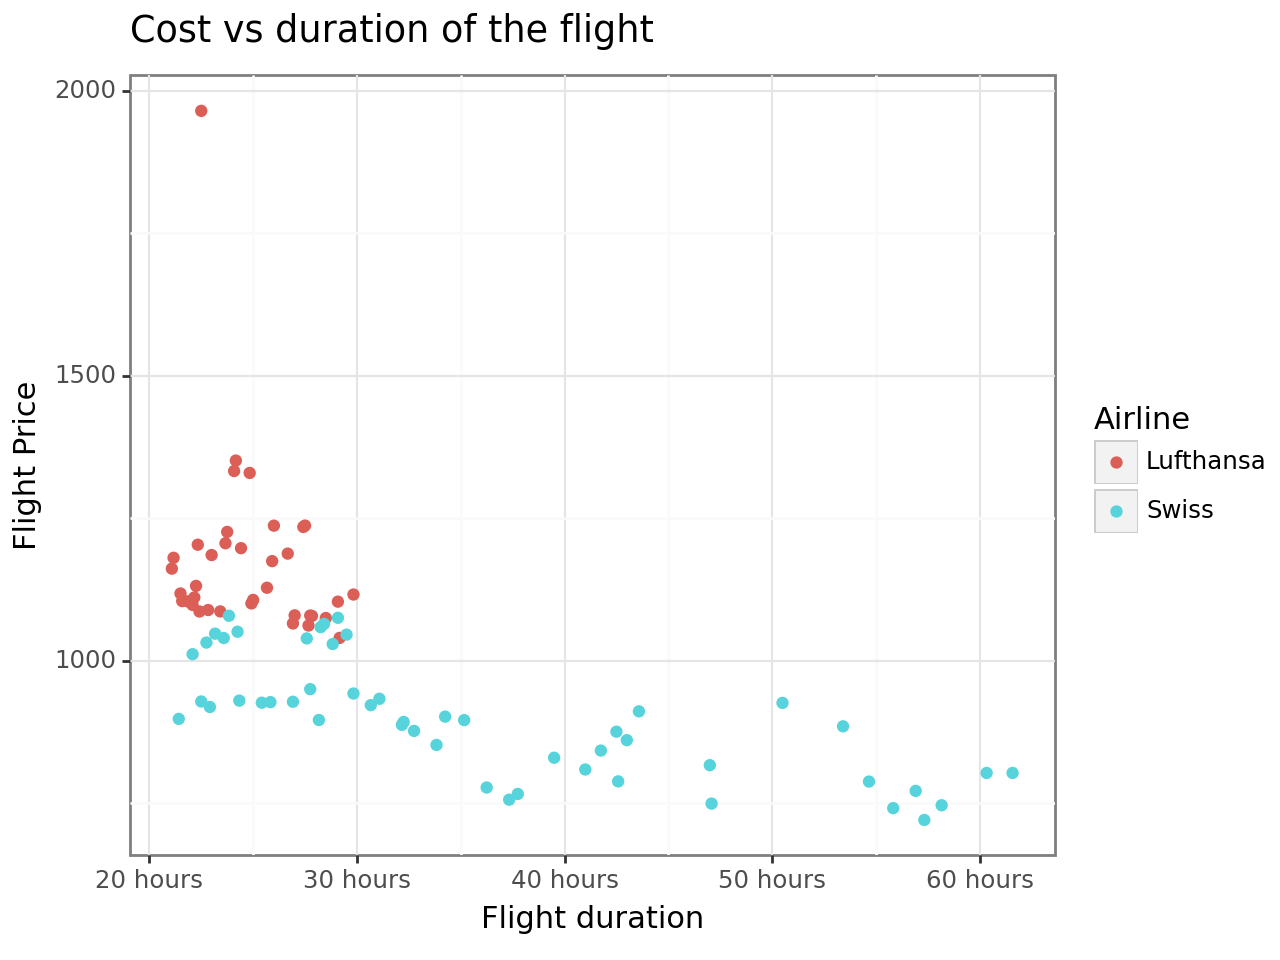

In [25]:
scatterplot(dataset=nyc)

**From Brussels to São Paulo**

In the case of Sao Paulo, the relationship is less apparent but still, both tends to be more negatively correlated than positive. For a same duration of flight, Lufthansa exhibits mostly higher cost.

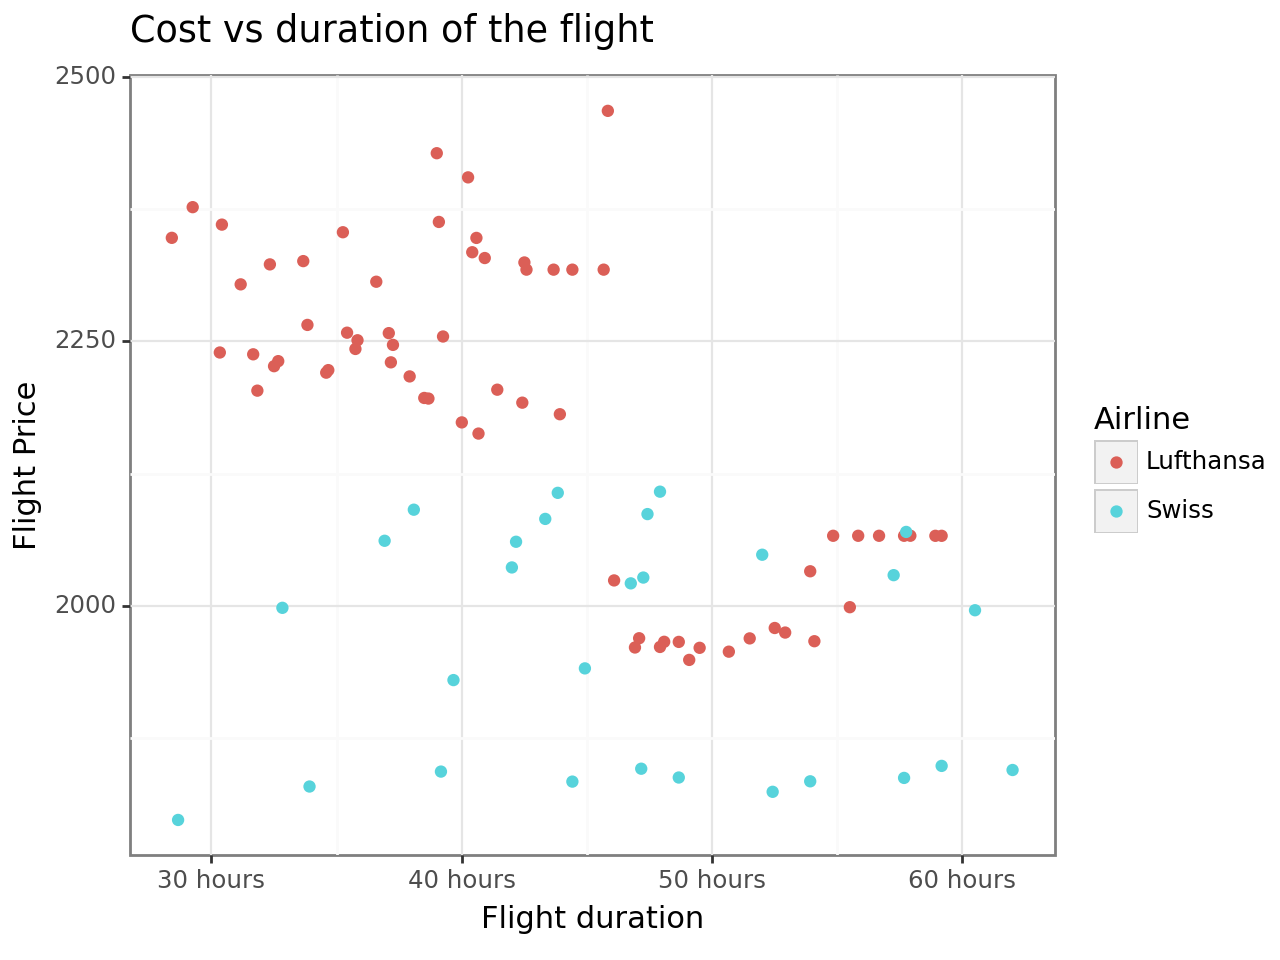

In [26]:
scatterplot(dataset=sao)

## Heatmap <a id="heatmap"></a>

### a. Heatmaps for flight prices

In [27]:
def plot_data(dataset=nyc):
    dataset['destination'] = dataset['arr_city'].replace({'JFK': 'New York City', 'GRU': 'São Paulo'})
    dataset["airline_company"] = dataset["out_airline_company"]
    data = dataset[["date", "ticket_price", "airline_company", "tot_duration", "destination"]]
    data['date'] = data['date'].dt.strftime('%d %b %I %p')
    data = data.sort_values(by='date', ascending = False)
    
    return data

In [28]:
def heatmap(data = plot_data(), y_axis : str= "date", x_axis : str= 'airline_company', val: str= 'ticket_price'):
    data_pivot = data.pivot_table(index = y_axis , columns= x_axis, values= val, aggfunc='mean')
    data_pivot.sort_index(ascending=False, inplace=True)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.heatmap(data_pivot)

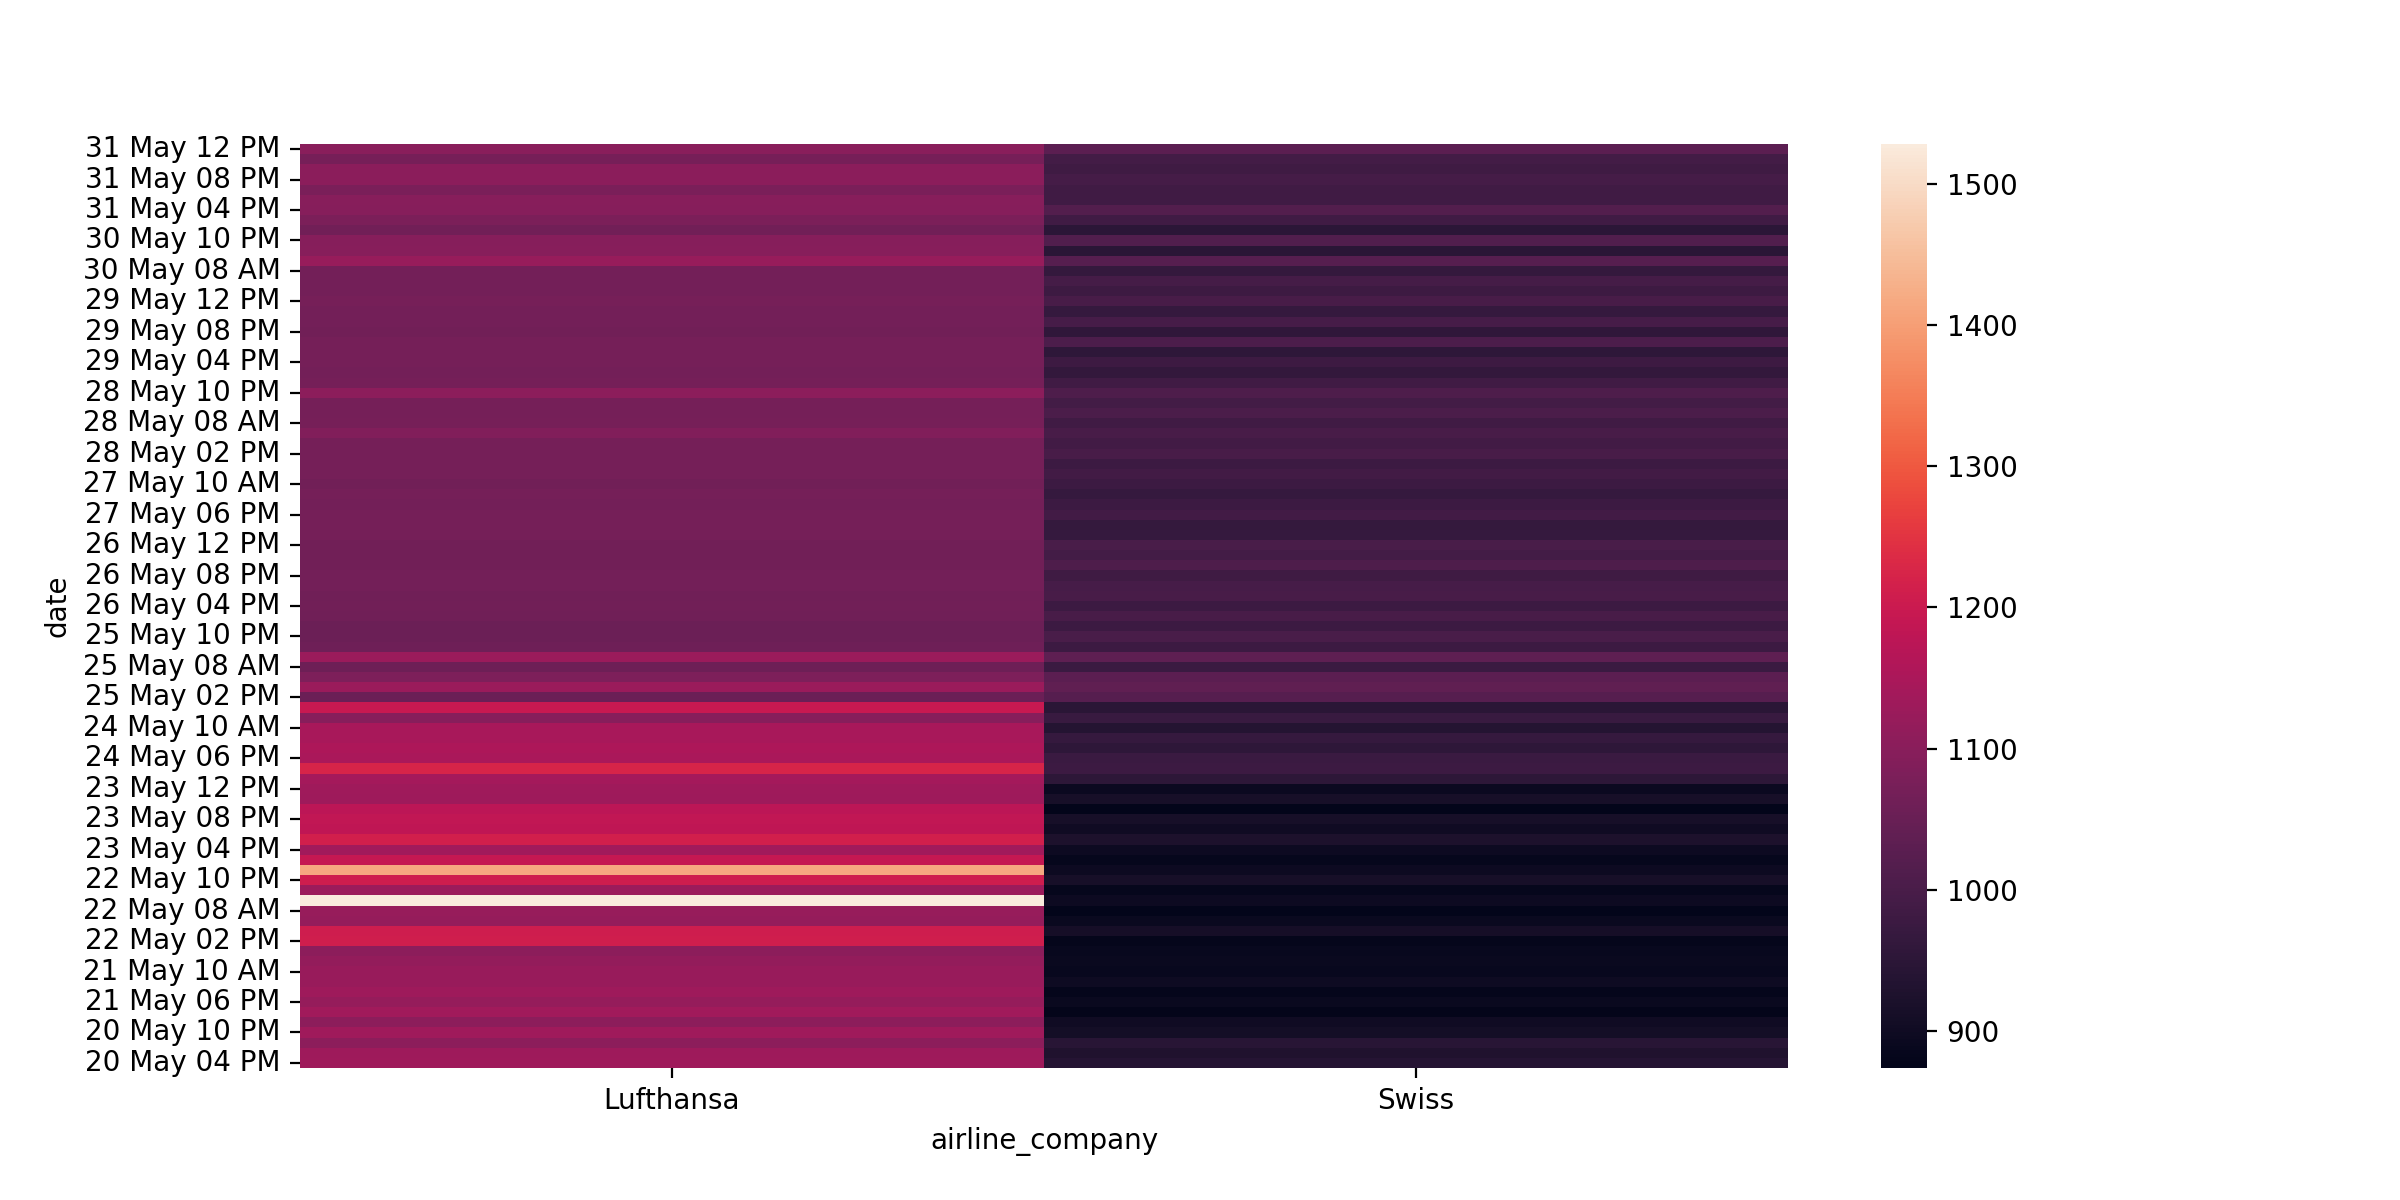

In [29]:
heatmap(plot_data(nyc))

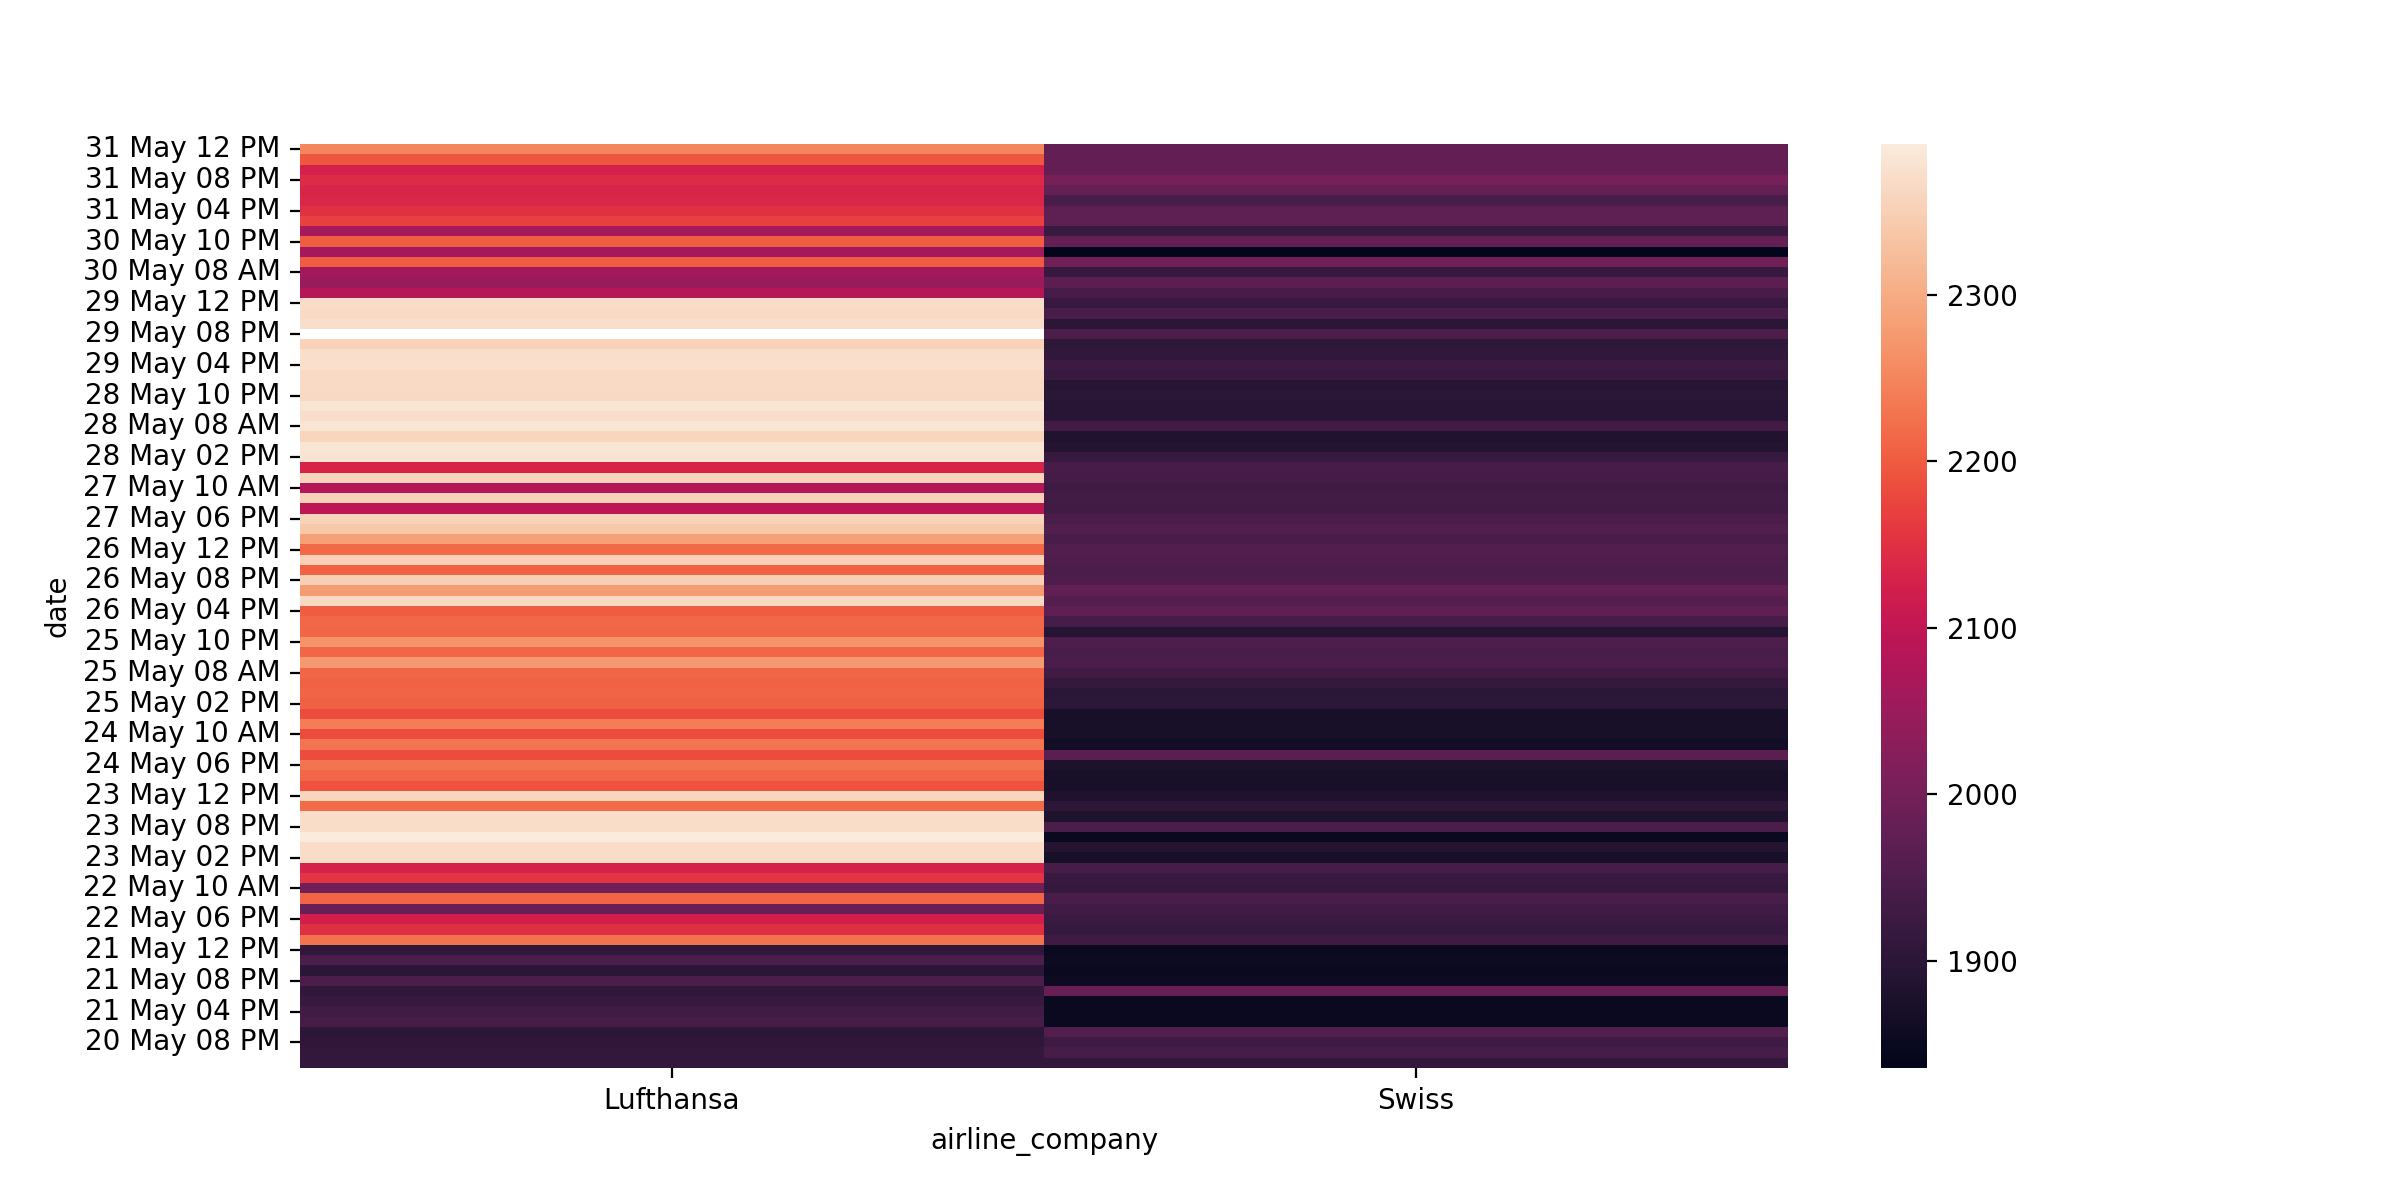

In [30]:
heatmap(plot_data(sao))

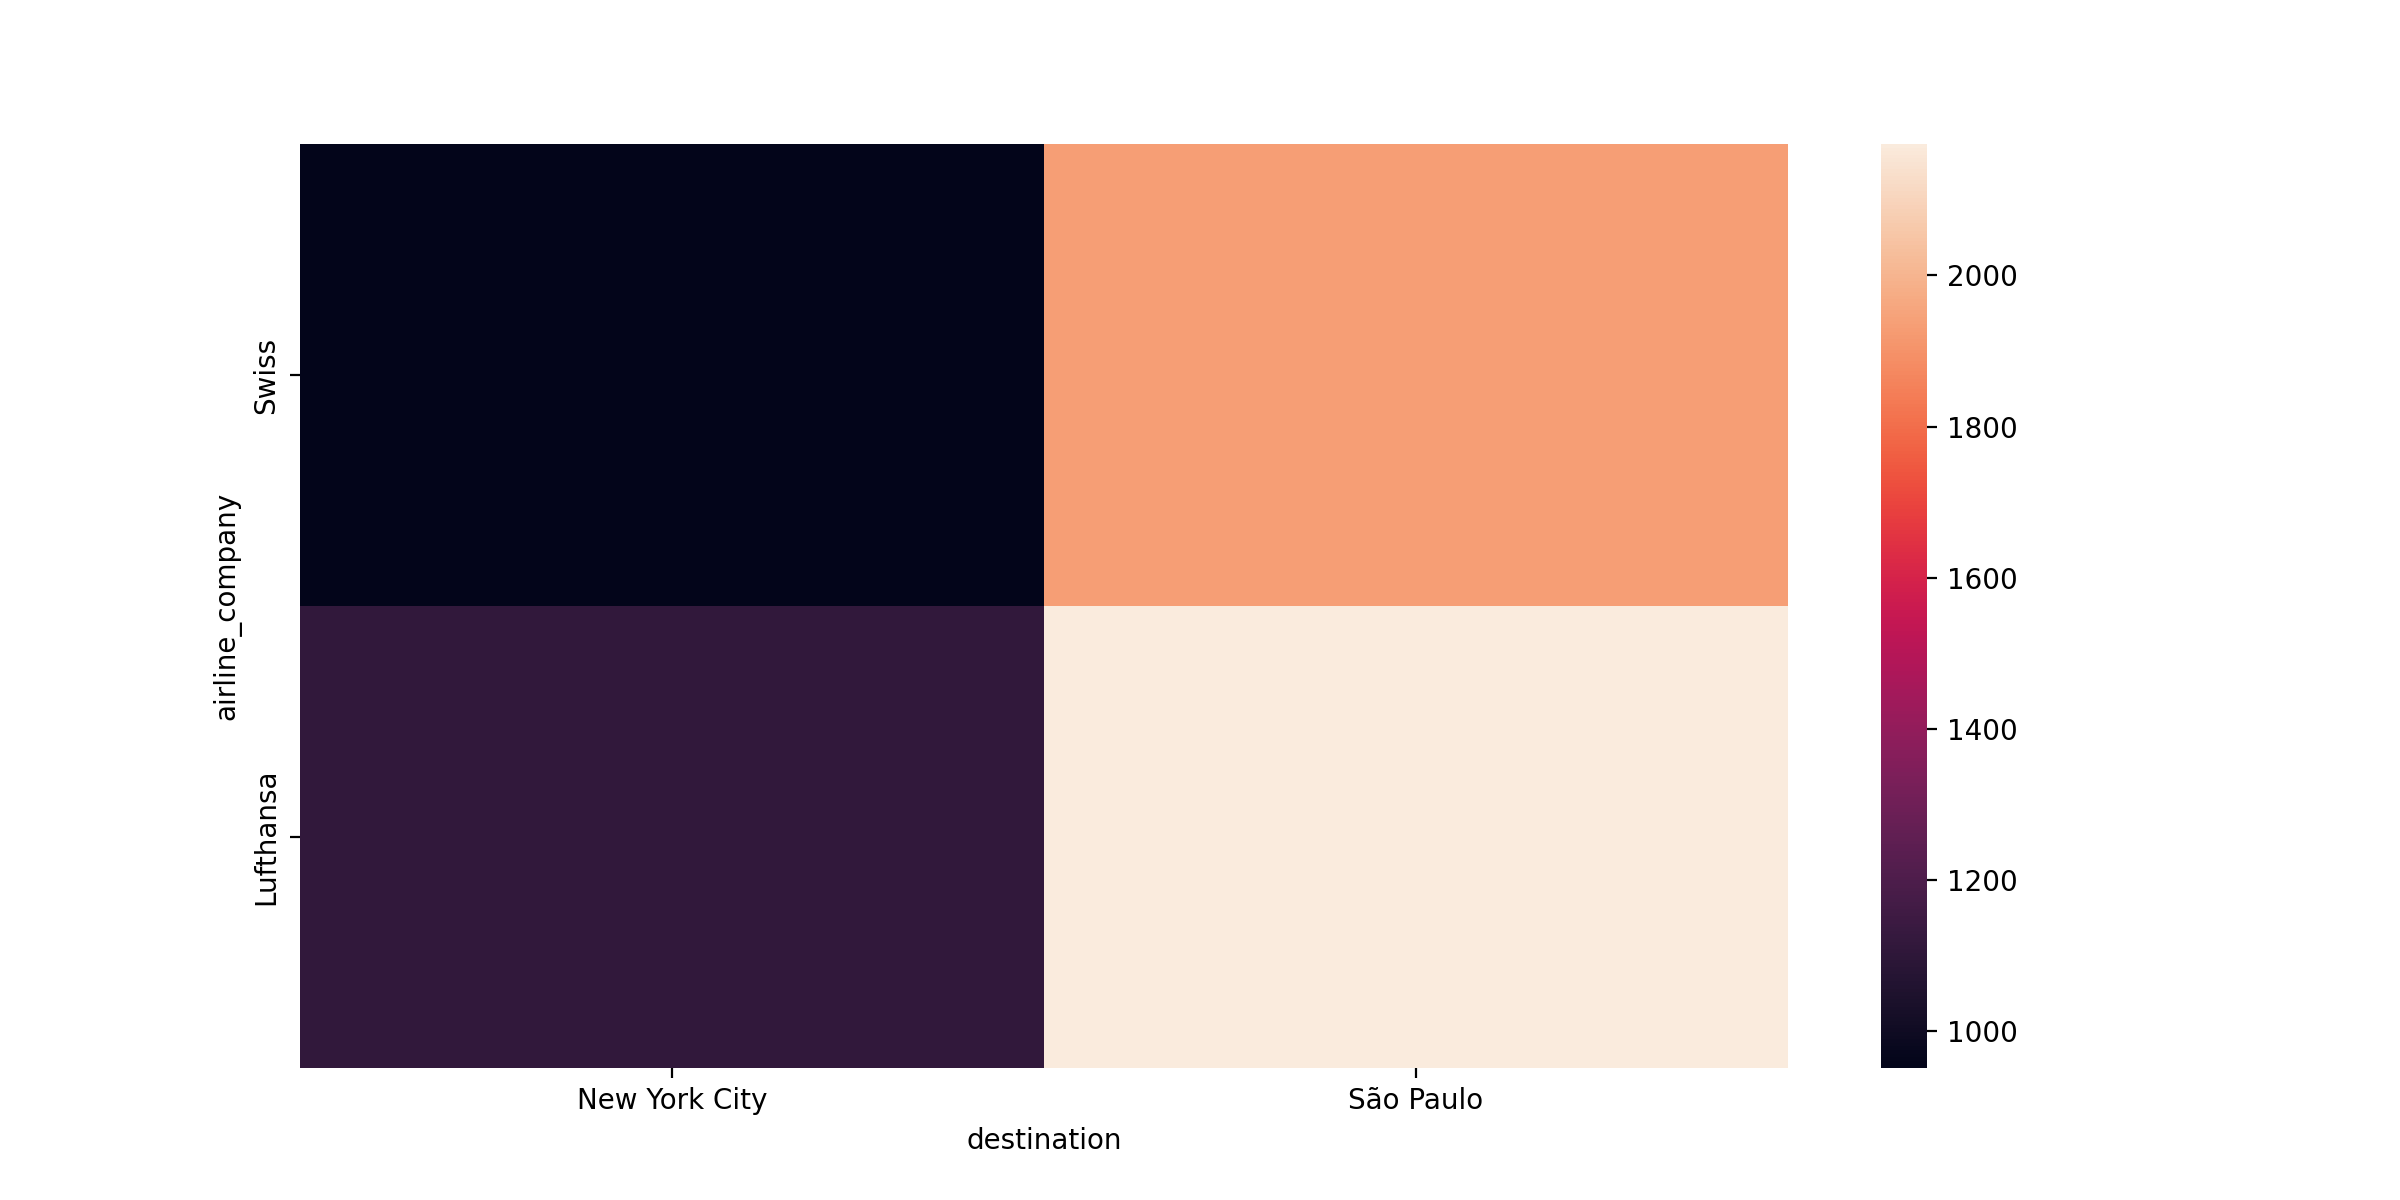

In [31]:
df_merge = pd.concat([plot_data(nyc), plot_data(sao)])
heatmap(data= df_merge, y_axis="airline_company", x_axis="destination")

### b. Correlation heatmap

The last step of the data visualization is to plot a heatmap of all the numerical variables, as to better identify the features that could be used in the data modelling part. The data set contains 19 variables including categorical and datetime data. However, correlation analysis is typically performed on numerical variables. These variables need to be converted first.

In [32]:
def clean_time(dataset): 
    heatmap = dataset[['out_dep_time', 'out_stop_num', 'out_arr_time', 'in_dep_time','in_stop_num', 'in_arr_time', 'hour_scrap', 'day_scrap', 'tot_duration', 'ticket_price']]
    # transform tot_duration to minutes
    heatmap['tot_duration']=heatmap['tot_duration'].dt.total_seconds() / 60
    # time from string to numerical
    time_heatmap = [col for col in heatmap.columns if col.endswith('_time')]
    for col in time_heatmap:
        heatmap[['hour', 'minute']] = heatmap[col].str.split(':', expand=True).astype(int)
        heatmap[col]=(heatmap['hour']*60)+heatmap['minute']
        heatmap.drop(['hour', 'minute'], axis=1, inplace=True)
    return heatmap

**From Brussels to New York City**

From the analysis for New York City, a clear and evident negative correlation can be observed between the ticket price and the duration of the flight, as the scatter plot already supported the same result. Then, the departure time seems to be also negatively correlated to our target y (price) for prediction. 

In [33]:
# the number of stop for NYC does not vary, it is always 1
heatmap_nyc=clean_time(dataset=nyc).drop(columns=['out_stop_num','in_stop_num'])

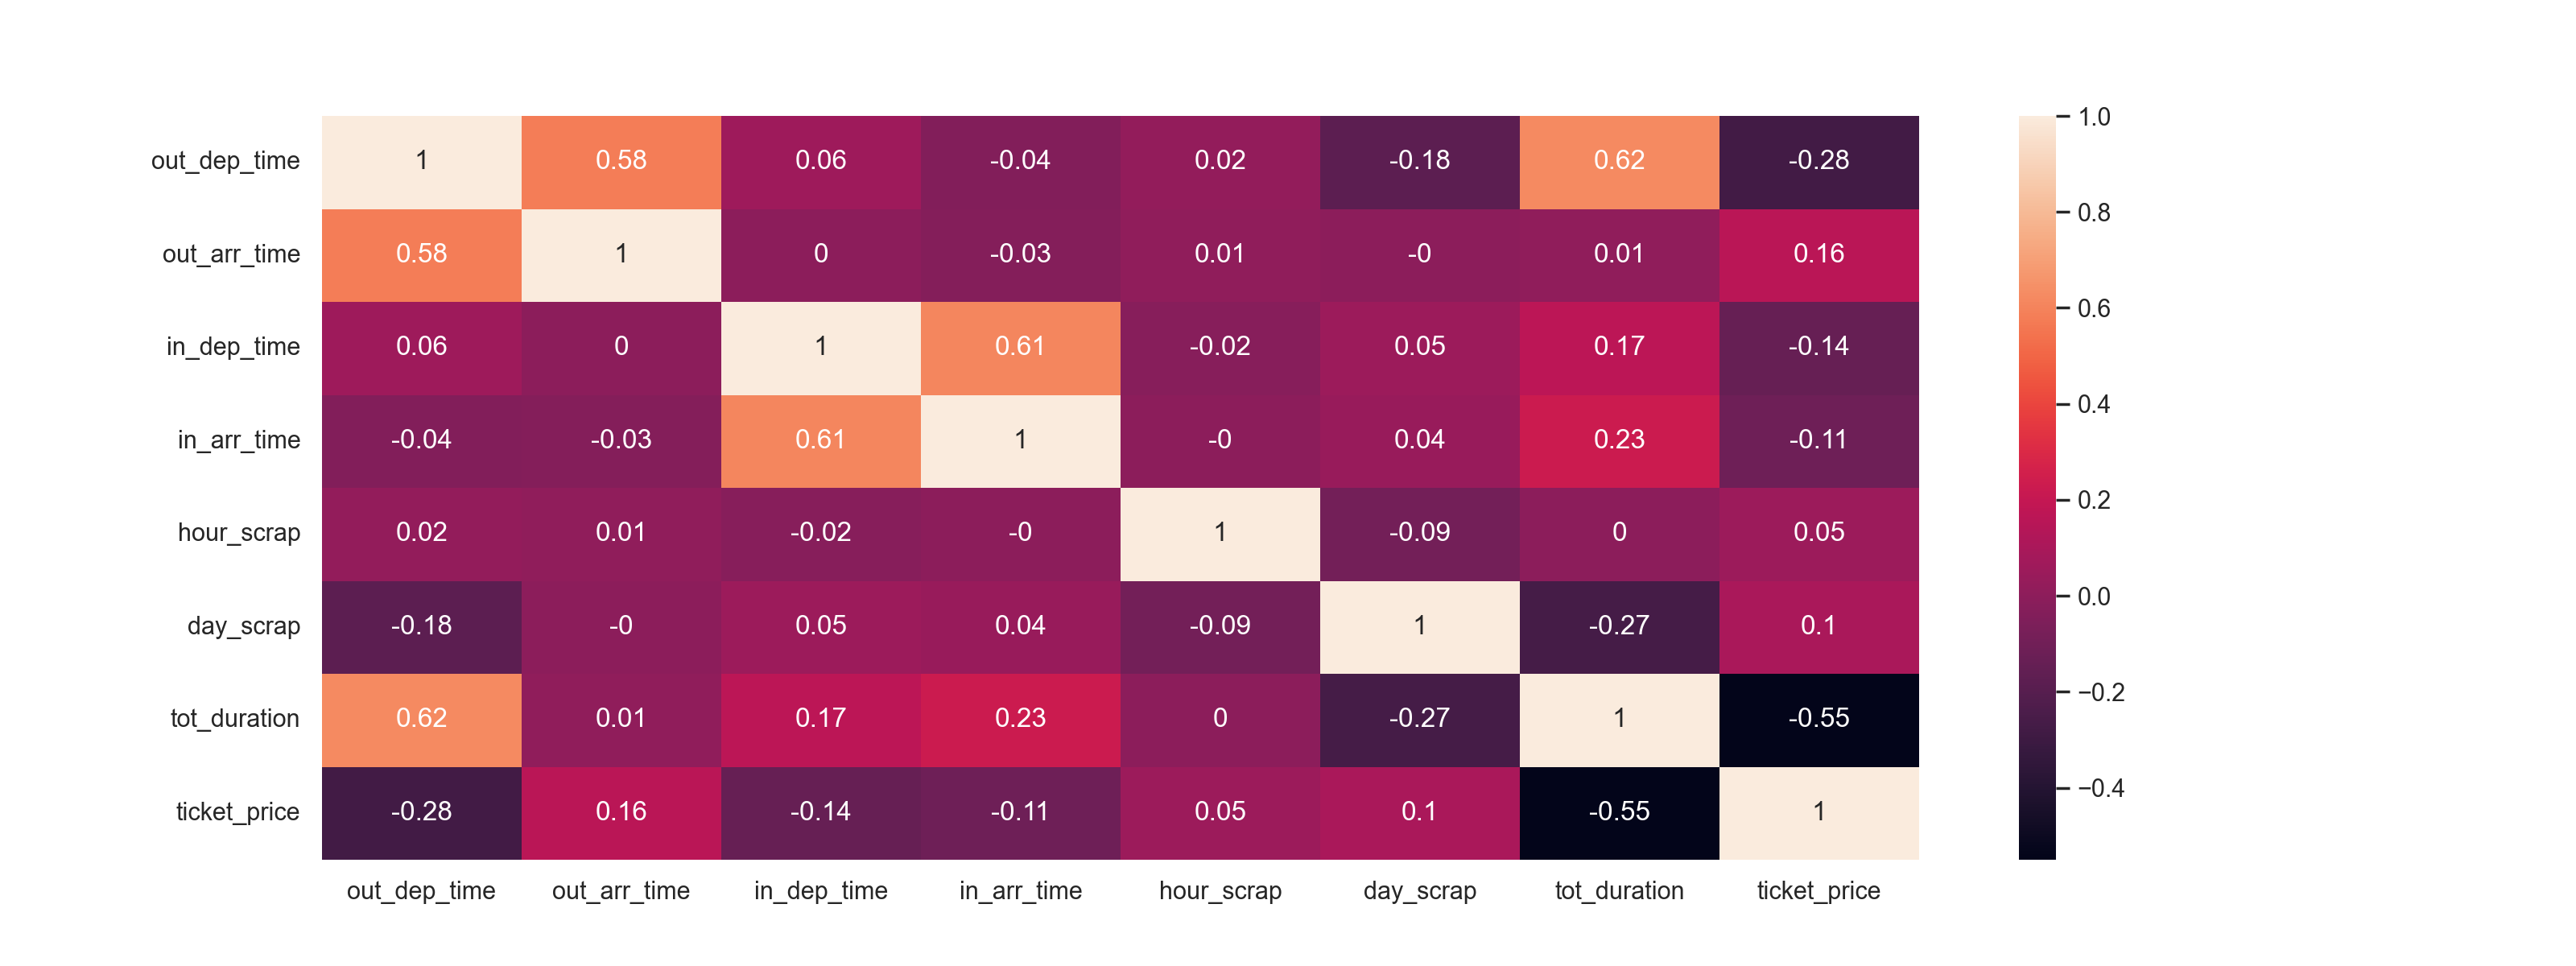

In [34]:
sns.set(rc={'figure.figsize':(16,6)})
correlation_matrix = heatmap_nyc.corr().round(2)
sns.heatmap(correlation_matrix, annot=True)
plt.show()

**From Brussels to Sao Paulo**

Prices also show stronger correlation with duration of the flight and variable related to time for the case of Sao Paulo.

In [35]:
heatmap_sao=clean_time(dataset=sao)

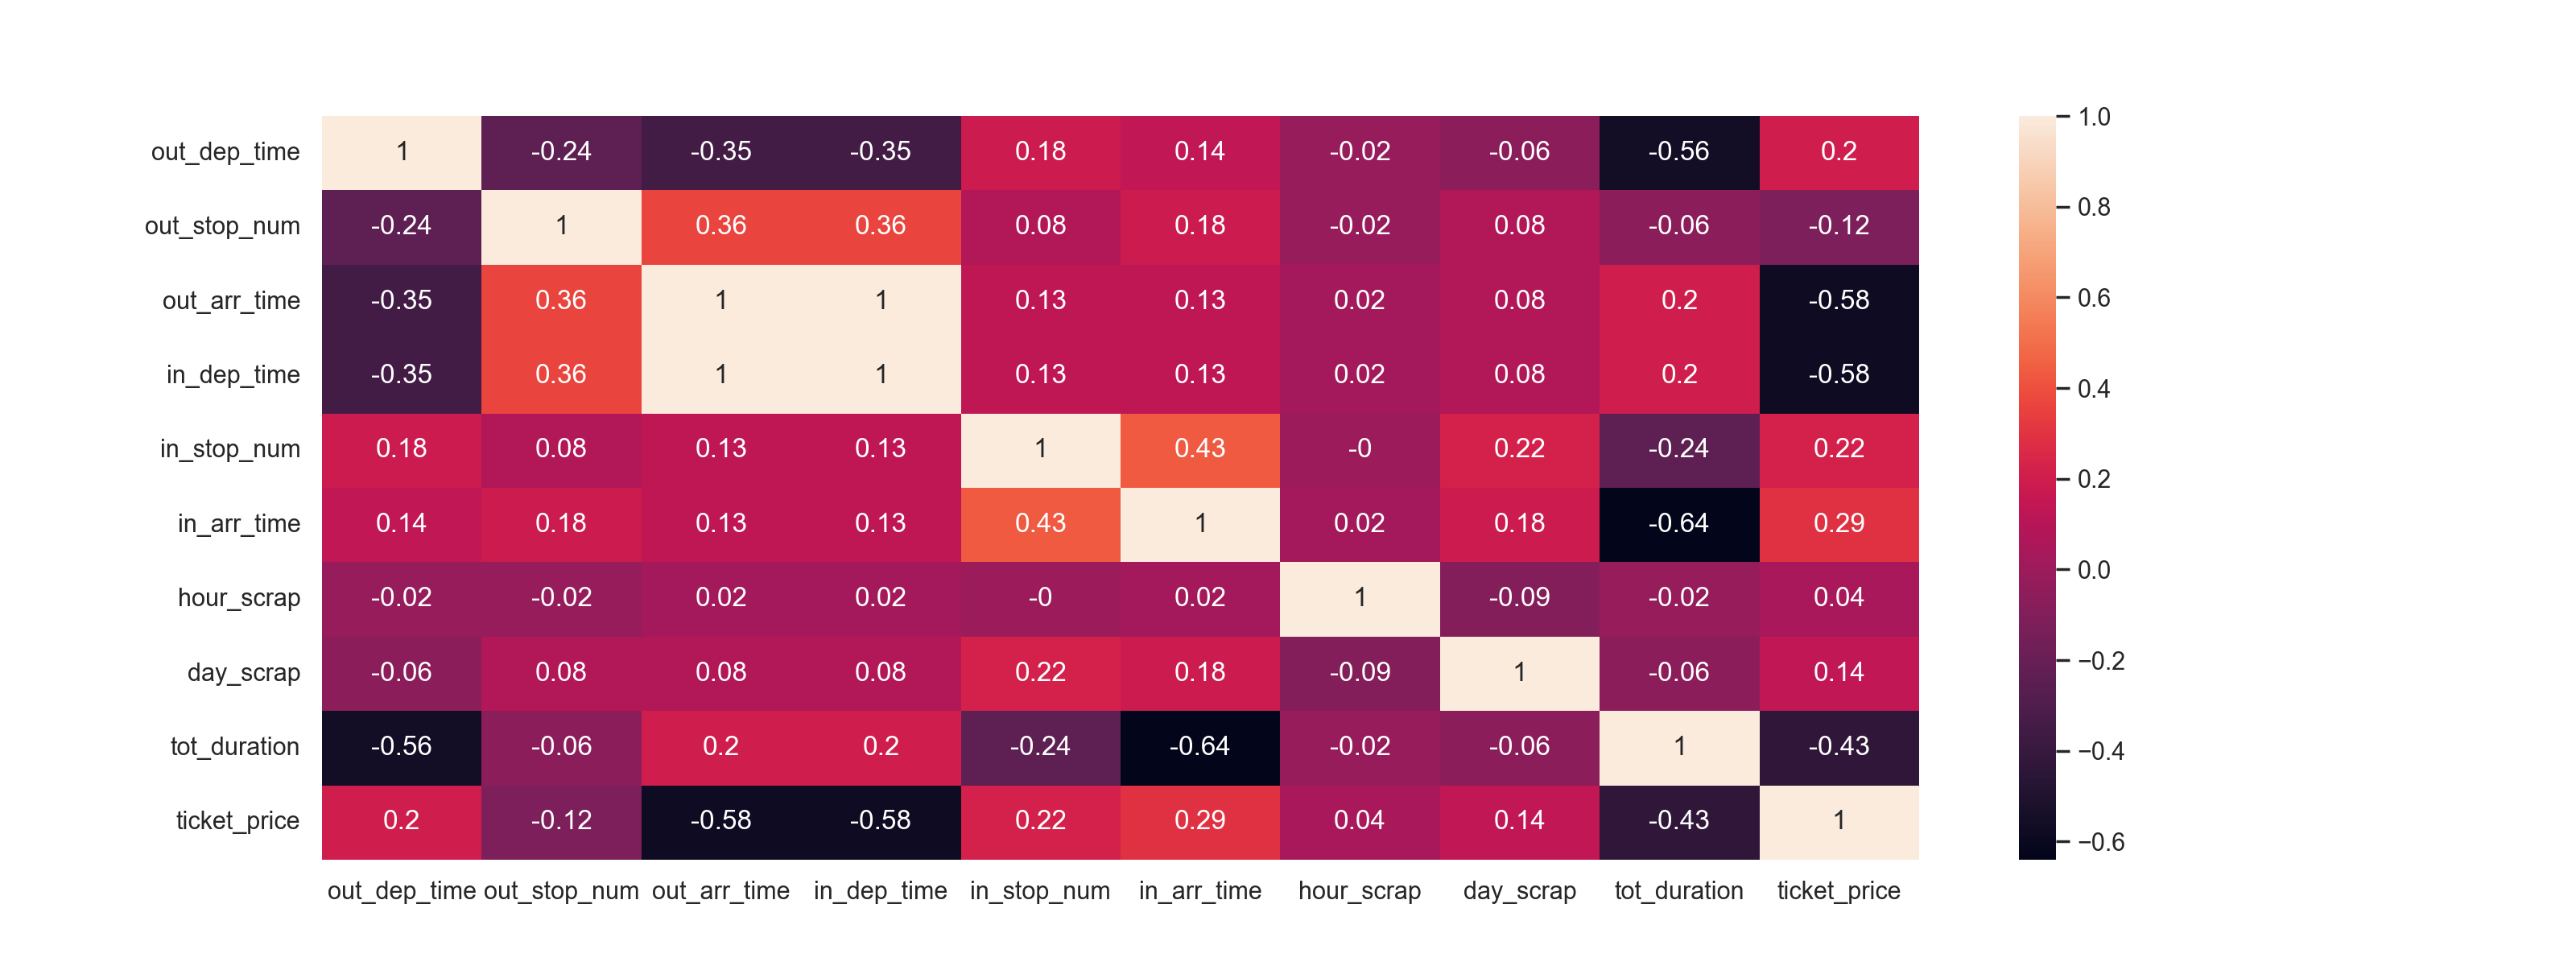

In [36]:
sns.set(rc={'figure.figsize':(16,6)})
correlation_matrix = heatmap_sao.corr().round(2)
sns.heatmap(correlation_matrix, annot=True)
plt.show()